# Boruta reduction

In [ ]:
import os
os.chdir('../')

--- Boruta Feature Selection on Metabolomics Data ---
Loaded log-transformed data from processing_data/log_transformed_mtb.tsv
Dataset shape: (352, 59833)
Found 59831 metabolic feature columns

Feature prefix distribution:
  C18n_: 13358 features
  C8p_: 19278 features
  HILp_: 17425 features
  HILn_: 9770 features

Prepared data for Boruta: X shape: (352, 59831), y shape: (352,)
Target classes: {'CD': 0, 'nonIBD': 1, 'UC': 2}

Initializing Boruta feature selection...
This may take a while for large datasets...
Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	59831
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	59831
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	59831
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	59831
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	59831
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	59831
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	59831
Rejected: 	0
Iteration: 	8 / 100
Confirme

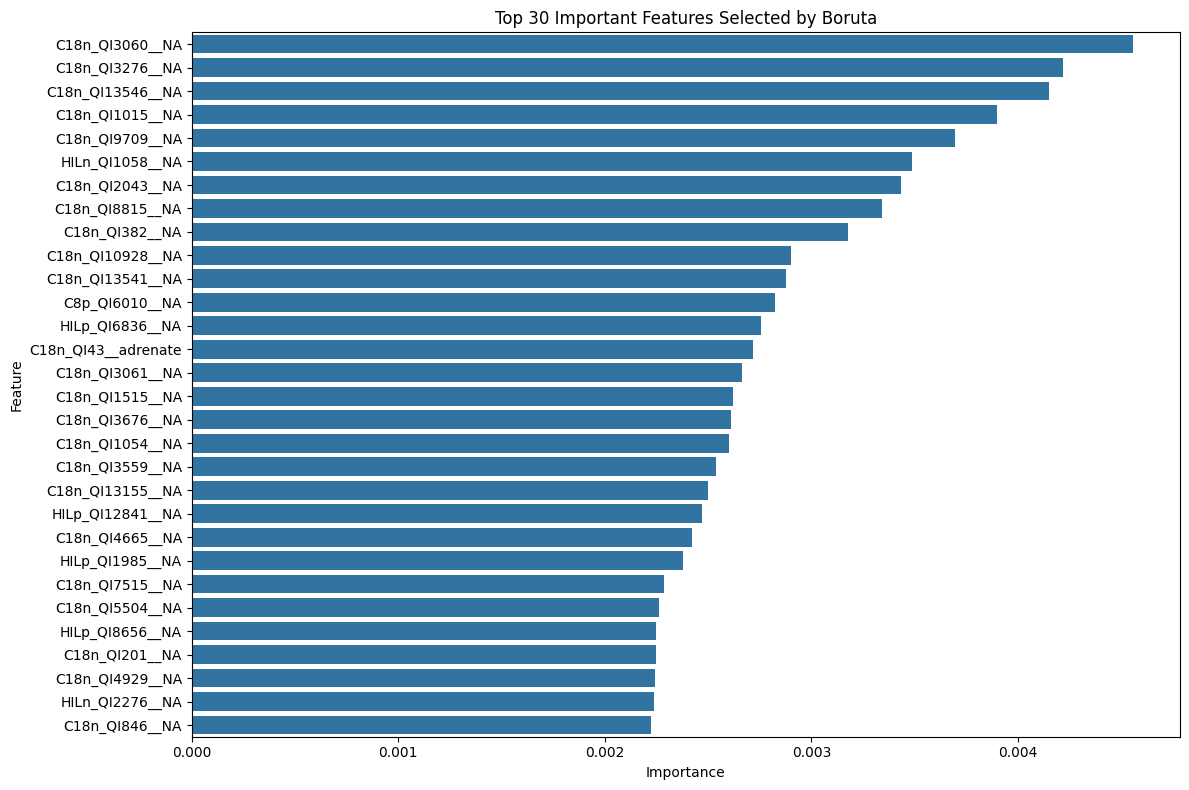

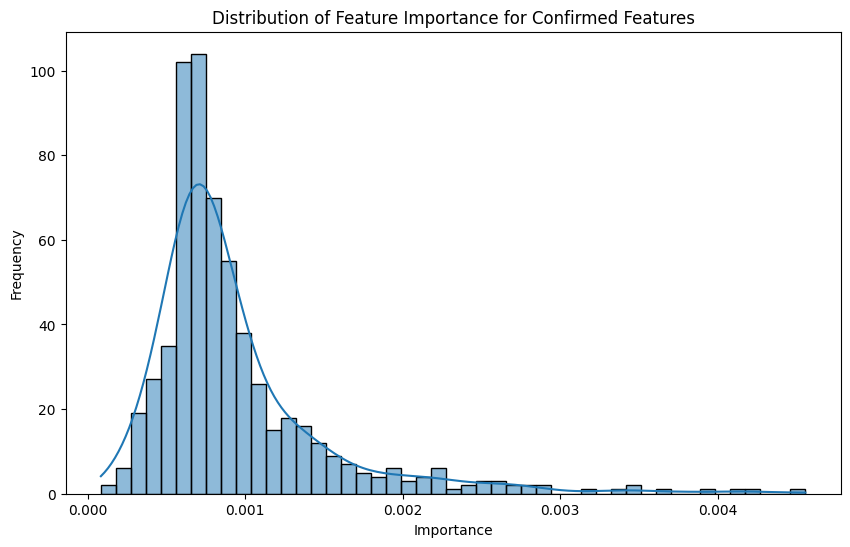


Prefix distribution in confirmed important features:
  C18n_: 290 features (2.2% of original C18n_ features)
  HILn_: 70 features (0.7% of original HILn_ features)
  C8p_: 108 features (0.6% of original C8p_ features)
  HILp_: 145 features (0.8% of original HILp_ features)

Boruta feature selection complete!


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier
import time
import pickle

print("--- Boruta Feature Selection on Metabolomics Data ---")

# --- 1. Load the log-transformed data ---
file_path = 'processing_data/log_transformed_mtb.tsv'
output_name_prefix = 'mtb'

try:
    log_transformed_df = pd.read_csv(file_path, sep='\t')
    print(f"Loaded log-transformed data from {file_path}")
    print(f"Dataset shape: {log_transformed_df.shape}")
except FileNotFoundError:
    print(f"Error: The file {file_path} was not found.")
    exit()

# --- 2. Extract metabolic feature columns ---
metabolic_prefixes = ['C18n_', 'C8p_', 'HILp_', 'HILn_']
metabolic_features = []

for prefix in metabolic_prefixes:
    prefix_cols = [col for col in log_transformed_df.columns if col.startswith(prefix)]
    metabolic_features.extend(prefix_cols)

if not metabolic_features:
    print("No metabolic feature columns found. Exiting.")
    exit()

print(f"Found {len(metabolic_features)} metabolic feature columns")

# prefix distribution
prefix_counts = {}
for feature in metabolic_features:
    for prefix in metabolic_prefixes:
        if feature.startswith(prefix):
            if prefix not in prefix_counts:
                prefix_counts[prefix] = 0
            prefix_counts[prefix] += 1
            break

print("\nFeature prefix distribution:")
for prefix, count in prefix_counts.items():
    print(f"  {prefix}: {count} features")

# --- 3. Prepare data for Boruta ---
# Check if Study.Group exists and has at least 2 classes
if 'Study.Group' not in log_transformed_df.columns:
    print("Error: 'Study.Group' column not found in the dataset.")
    exit()

if len(log_transformed_df['Study.Group'].unique()) < 2:
    print("Error: 'Study.Group' needs at least 2 classes for classification.")
    print(f"Found classes: {log_transformed_df['Study.Group'].unique()}")
    exit()

# Convert Study.Group to numeric labels
label_map = {label: i for i, label in enumerate(log_transformed_df['Study.Group'].unique())}
y = log_transformed_df['Study.Group'].map(label_map).values

# Get feature matrix
X = log_transformed_df[metabolic_features].values

print(f"\nPrepared data for Boruta: X shape: {X.shape}, y shape: {y.shape}")
print(f"Target classes: {label_map}")

# --- 4. Run Boruta ---
print("\nInitializing Boruta feature selection...")
print("This may take a while for large datasets...")

# Set up the Boruta algorithm
rf = RandomForestClassifier(
    n_jobs=-1,           # Use all cores
    class_weight='balanced',
    max_depth=7,         # Limit depth to avoid overfitting
    n_estimators=100,    # Start with 100 trees
    random_state=42
)

# Initialize Boruta
boruta = BorutaPy(
    estimator=rf,
    n_estimators='auto',  # Auto-select number of estimators
    verbose=2,            # Show progress
    random_state=42,
    max_iter=100          # Maximum iterations
)

# Record start time
start_time = time.time()

# Run Boruta
try:
    boruta.fit(X, y)
    # Calculate and display runtime
    runtime = time.time() - start_time
    print(f"\nBoruta completed in {runtime:.2f} seconds ({runtime/60:.2f} minutes)")
    # Save the Boruta model
    with open(f'processing_data/{output_name_prefix}_model.pkl', 'wb') as f:
        pickle.dump(boruta, f)
    print(f"Saved Boruta model to processing_data/{output_name_prefix}_model.pkl")
    
except Exception as e:
    print(f"Error during Boruta fitting: {e}")
    exit()

# --- 5. Analyze and save results ---
# Get feature ranking and importance
feature_ranks = pd.DataFrame({
    'Feature': metabolic_features,
    'Rank': boruta.ranking_,
    'Support': boruta.support_,
    'Tentative': boruta.support_weak_,
    'Importance': boruta.importance_history_.mean(axis=0)
})

# Sort by importance
feature_ranks = feature_ranks.sort_values('Importance', ascending=False)

# Save all feature rankings
feature_ranks.to_csv(f'processing_data/{output_name_prefix}_all_features_ranked.tsv', sep='\t', index=False)
print(f"\nSaved all feature rankings to processing_data/{output_name_prefix}_all_features_ranked.tsv")

# Get confirmed important features
confirmed_features = feature_ranks[feature_ranks['Support'] == True]
print(f"\nBoruta confirmed {len(confirmed_features)} important features")

# Save confirmed features
confirmed_features.to_csv(f'processing_data/{output_name_prefix}_confirmed_features.tsv', sep='\t', index=False)
print(f"Saved confirmed features to processing_data/{output_name_prefix}_confirmed_features.tsv")

# --- 6. Create filtered dataset ---
# Filter dataset to include only confirmed important features
confirmed_feature_names = confirmed_features['Feature'].tolist()
filtered_df = log_transformed_df[['Sample', 'Study.Group'] + confirmed_feature_names]

# Save filtered dataset
filtered_df.to_csv(f'processing_data/boruta_filtered_{output_name_prefix}.tsv', sep='\t', index=False)
print(f"Saved filtered dataset with only important features to processing_data/boruta_filtered_{output_name_prefix}.tsv")

# --- 7. Visualize results ---
# Plot feature importance
plt.figure(figsize=(12, 8))
features_to_plot = min(30, len(confirmed_features))  # Limit to top 30 features for readability
sns.barplot(x='Importance', y='Feature', data=confirmed_features.head(features_to_plot))
plt.title(f'Top {features_to_plot} Important Features Selected by Boruta')
plt.tight_layout()
plt.show()

# Plot feature importance distribution
plt.figure(figsize=(10, 6))
sns.histplot(confirmed_features['Importance'], kde=True)
plt.title('Distribution of Feature Importance for Confirmed Features')
plt.xlabel('Importance')
plt.ylabel('Frequency')
plt.show()

# Prefix distribution in confirmed features
prefix_counts_confirmed = {}
for feature in confirmed_feature_names:
    for prefix in metabolic_prefixes:
        if feature.startswith(prefix):
            if prefix not in prefix_counts_confirmed:
                prefix_counts_confirmed[prefix] = 0
            prefix_counts_confirmed[prefix] += 1
            break

print("\nPrefix distribution in confirmed important features:")
for prefix, count in prefix_counts_confirmed.items():
    original_count = prefix_counts.get(prefix, 0)
    if original_count > 0:
        percentage = (count / original_count) * 100
        print(f"  {prefix}: {count} features ({percentage:.1f}% of original {prefix} features)")

print("\nBoruta feature selection complete!")

# CD Subtype Identification

--- K-determination for CD Subtypes from: processing_data/boruta_filtered_mtb.tsv ---
Shape of loaded full dataset: (352, 615)
Shape of CD-only dataset: (155, 615)
Identified 613 feature columns for clustering CD subtypes.
Shape of feature matrix for CD subtype clustering: (155, 613)
CD features standardized for clustering.
------------------------------

--- Elbow Method for Optimal K (CD Subtypes) ---
SSE for K=2 (CD subtypes): 63364.01
SSE for K=3 (CD subtypes): 57870.31
SSE for K=4 (CD subtypes): 54526.45
SSE for K=5 (CD subtypes): 51534.62
SSE for K=6 (CD subtypes): 49541.64
SSE for K=7 (CD subtypes): 48415.23
SSE for K=8 (CD subtypes): 46355.15
SSE for K=9 (CD subtypes): 45096.03
SSE for K=10 (CD subtypes): 44328.77


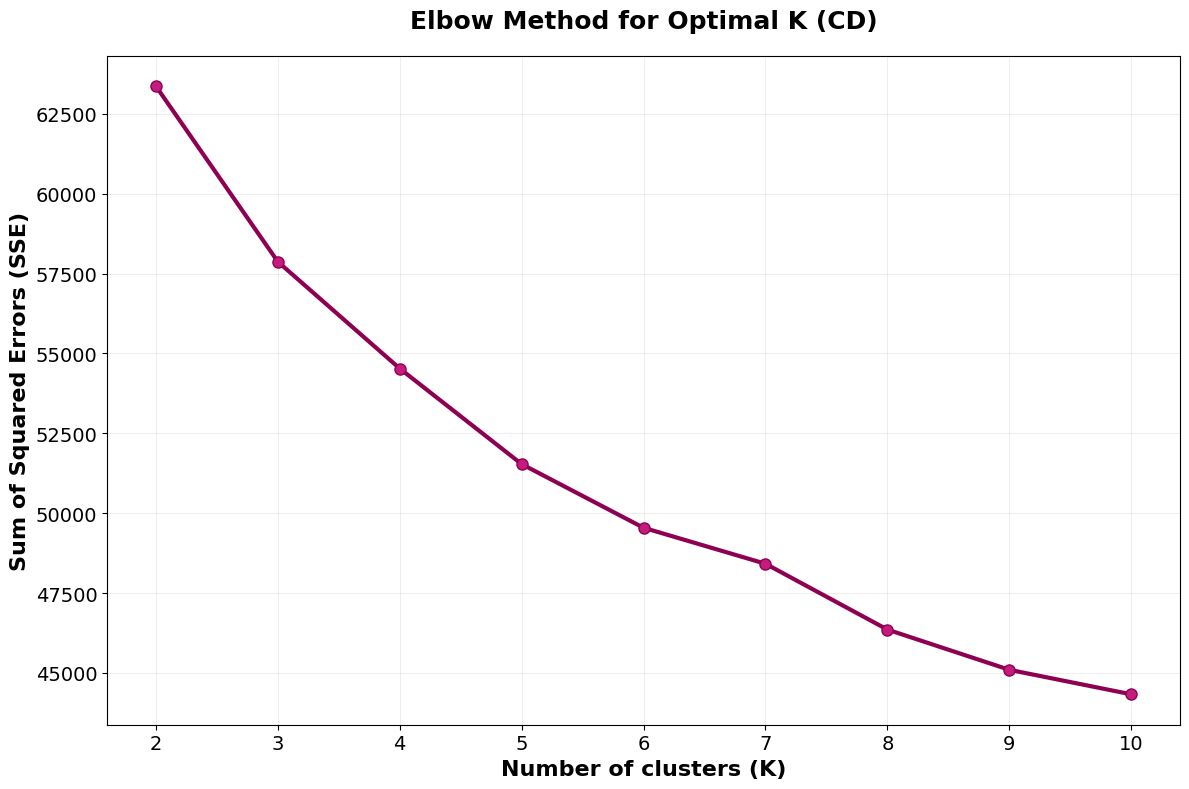

Look for an 'elbow' in the plot.
------------------------------

--- Silhouette Analysis for Optimal K (CD Subtypes) ---
Silhouette Score for K=2 (CD subtypes): 0.3338
Silhouette Score for K=3 (CD subtypes): 0.1589
Silhouette Score for K=4 (CD subtypes): 0.1169
Silhouette Score for K=5 (CD subtypes): 0.1046
Silhouette Score for K=6 (CD subtypes): 0.1084
Silhouette Score for K=7 (CD subtypes): 0.0940
Silhouette Score for K=8 (CD subtypes): 0.1064
Silhouette Score for K=9 (CD subtypes): 0.1083
Silhouette Score for K=10 (CD subtypes): 0.0918


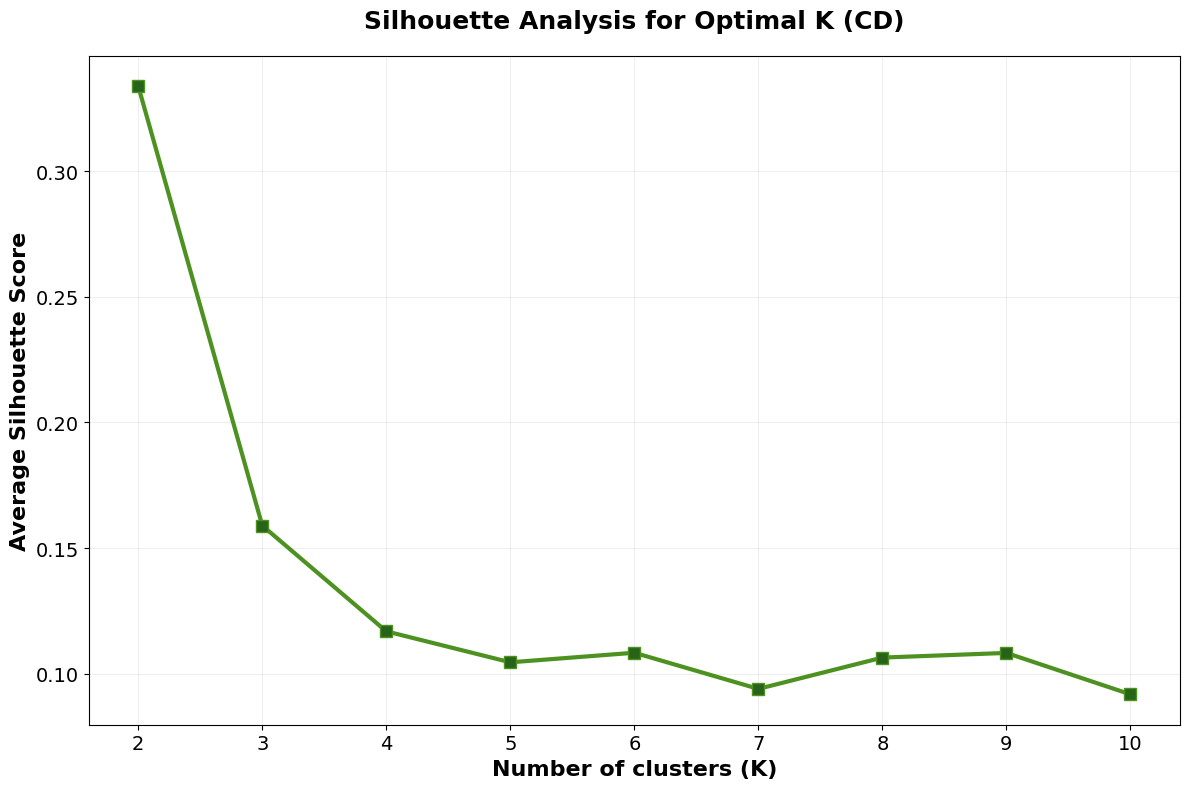

Look for the K that maximizes the Silhouette Score.
------------------------------


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# --- 1. Load Your Combined, Reduced, and Log-Transformed Dataset ---
file_path_reduced_data = 'processing_data/boruta_filtered_mtb.tsv' 
dataset_name_prefix = 'CD' # For context in outputs

try:
    full_processed_df = pd.read_csv(file_path_reduced_data, sep='\t')
except FileNotFoundError:
    print(f"Error: The file {file_path_reduced_data} was not found. Using placeholder.")

print(f"--- K-determination for CD Subtypes from: {file_path_reduced_data} ---")
print(f"Shape of loaded full dataset: {full_processed_df.shape}")

# --- 2. Filter for CD Patients Only ---
if 'Study.Group' not in full_processed_df.columns:
    print("Error: 'Study.Group' column not found. Cannot filter for CD patients.")
    cd_only_df = pd.DataFrame() # Empty df
else:
    cd_only_df = full_processed_df[full_processed_df['Study.Group'] == 'CD'].copy()

if cd_only_df.empty:
    print("No CD patients found in the dataset. Exiting CD subtype analysis.")
    scaled_features_cd = None
else:
    print(f"Shape of CD-only dataset: {cd_only_df.shape}")

    # --- 3. Prepare Data for Clustering (CD samples) ---
    # Feature columns are all columns except 'Sample' and 'Study.Group'
    feature_columns_cd = [col for col in cd_only_df.columns if col not in ['Sample', 'Study.Group']]

    if not feature_columns_cd:
        print("No feature columns found in CD-only data. Exiting.")
        scaled_features_cd = None 
    else:
        print(f"Identified {len(feature_columns_cd)} feature columns for clustering CD subtypes.")
        features_for_clustering_cd = cd_only_df[feature_columns_cd].copy()

        # To check that all feature data is numeric
        for col in features_for_clustering_cd.columns: 
            features_for_clustering_cd[col] = pd.to_numeric(features_for_clustering_cd[col], errors='coerce')
        
        features_for_clustering_cd.dropna(axis=1, how='all', inplace=True) # Drop all-NaN columns
        features_for_clustering_cd.dropna(axis=0, how='all', inplace=True) # Drop all-NaN rows
        
        if features_for_clustering_cd.empty or features_for_clustering_cd.shape[1] == 0:
            print("No valid feature data remains after NaN checks for CD samples. Cannot proceed.")
            scaled_features_cd = None
        else:
            print(f"Shape of feature matrix for CD subtype clustering: {features_for_clustering_cd.shape}")
            # Scale the features
            scaler_cd = StandardScaler()
            scaled_features_cd = scaler_cd.fit_transform(features_for_clustering_cd)
            print("CD features standardized for clustering.")
            print("-" * 30)

if scaled_features_cd is not None and scaled_features_cd.shape[0] > 1: # Need at least 2 samples for Kmeans

    colors = ['#8e0152','#c51b7d','#de77ae','#f1b6da','#fde0ef','#e6f5d0','#b8e186','#7fbc41','#4d9221','#276419']

    # --- 4. Determine Optimal K using Elbow Method (for CD subtypes) ---
    print("\n--- Elbow Method for Optimal K (CD Subtypes) ---")
    sse_cd = {} 
    max_k_cd = min(11, scaled_features_cd.shape[0]) # K up to 10
    k_range_cd = range(2, max_k_cd) 

    if len(k_range_cd) < 1:
        print(f"Not enough CD samples ({scaled_features_cd.shape[0]}) to test a range of K values >= 2.")
    else:
        for k in k_range_cd:
            kmeans_cd = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=42, algorithm='lloyd')
            kmeans_cd.fit(scaled_features_cd)
            sse_cd[k] = kmeans_cd.inertia_ 
            print(f"SSE for K={k} (CD subtypes): {sse_cd[k]:.2f}")

        plt.figure(figsize=(12, 8))
        plt.plot(list(sse_cd.keys()), list(sse_cd.values()), 
                color=colors[0], marker='o', markersize=8, linewidth=3, markerfacecolor=colors[1])
        plt.xlabel('Number of clusters (K)', fontsize=16, fontweight='bold')
        plt.ylabel('Sum of Squared Errors (SSE)', fontsize=16, fontweight='bold')
        plt.title(f'Elbow Method for Optimal K ({dataset_name_prefix})', fontsize=18, fontweight='bold', pad=20)
        plt.xticks(list(k_range_cd), fontsize=14)
        plt.yticks(fontsize=14)
        plt.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
        plt.tight_layout()
        plt.show()
        print("Look for an 'elbow' in the plot.")
    print("-" * 30)

    # --- 5. Determine Optimal K using Silhouette Analysis (for CD subtypes) ---
    print("\n--- Silhouette Analysis for Optimal K (CD Subtypes) ---")
    silhouette_scores_cd = {}
    if len(k_range_cd) < 1:
        print(f"Not enough CD samples ({scaled_features_cd.shape[0]}) for Silhouette analysis with K >= 2.")
    else:
        for k in k_range_cd: 
            kmeans_cd = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=42, algorithm='lloyd')
            cluster_labels_cd = kmeans_cd.fit_predict(scaled_features_cd)
            try:
                # Ensures there's more than 1 unique label and k < n_samples for silhouette
                if len(np.unique(cluster_labels_cd)) > 1 and len(np.unique(cluster_labels_cd)) < len(scaled_features_cd):
                    silhouette_avg_cd = silhouette_score(scaled_features_cd, cluster_labels_cd)
                    silhouette_scores_cd[k] = silhouette_avg_cd
                    print(f"Silhouette Score for K={k} (CD subtypes): {silhouette_avg_cd:.4f}")
                else:
                    print(f"Could not calculate silhouette score for K={k} (CD subtypes): not enough unique clusters or samples (Unique labels: {len(np.unique(cluster_labels_cd))}, Samples: {len(scaled_features_cd)}).")
                    silhouette_scores_cd[k] = -1 # Invalid score
            except ValueError as e:
                print(f"Could not calculate silhouette score for K={k} (CD subtypes): {e}.")
                silhouette_scores_cd[k] = -1 

        plt.figure(figsize=(12, 8))
        valid_silhouette_k_cd = [k_val for k_val, score in silhouette_scores_cd.items() if score > -1] 
        valid_silhouette_v_cd = [score for k_val, score in silhouette_scores_cd.items() if score > -1]
        
        if valid_silhouette_k_cd:
            plt.plot(valid_silhouette_k_cd, valid_silhouette_v_cd, 
                    color=colors[8], marker='s', markersize=8, linewidth=3, markerfacecolor=colors[9])
            plt.xlabel('Number of clusters (K)', fontsize=16, fontweight='bold')
            plt.ylabel('Average Silhouette Score', fontsize=16, fontweight='bold')
            plt.title(f'Silhouette Analysis for Optimal K ({dataset_name_prefix})', fontsize=18, fontweight='bold', pad=20)
            plt.xticks(valid_silhouette_k_cd, fontsize=14)
            plt.yticks(fontsize=14)
            plt.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
            plt.tight_layout()
            plt.show()
            print("Look for the K that maximizes the Silhouette Score.")
        else:
            print("Could not plot silhouette scores as none were successfully computed for CD subtypes.")
    print("-" * 30)
else:
    print(f"K-determination for CD subtypes skipped as no valid feature data was available for CD samples.")

# UC Subtype Identification

--- K-determination for UC Subtypes from: processing_data/boruta_filtered_mtb.tsv ---
Shape of loaded full dataset: (352, 615)
Shape of UC-only dataset: (96, 615)
Identified 613 feature columns for clustering UC subtypes.
Shape of feature matrix for UC subtype clustering: (96, 613)
UC features standardized for clustering.
------------------------------

--- Elbow Method for Optimal K (UC Subtypes) ---
SSE for K=2 (UC subtypes): 41203.41
SSE for K=3 (UC subtypes): 37962.51
SSE for K=4 (UC subtypes): 35377.25
SSE for K=5 (UC subtypes): 33353.51
SSE for K=6 (UC subtypes): 32015.99
SSE for K=7 (UC subtypes): 30780.30
SSE for K=8 (UC subtypes): 29587.29
SSE for K=9 (UC subtypes): 28996.09
SSE for K=10 (UC subtypes): 28196.02


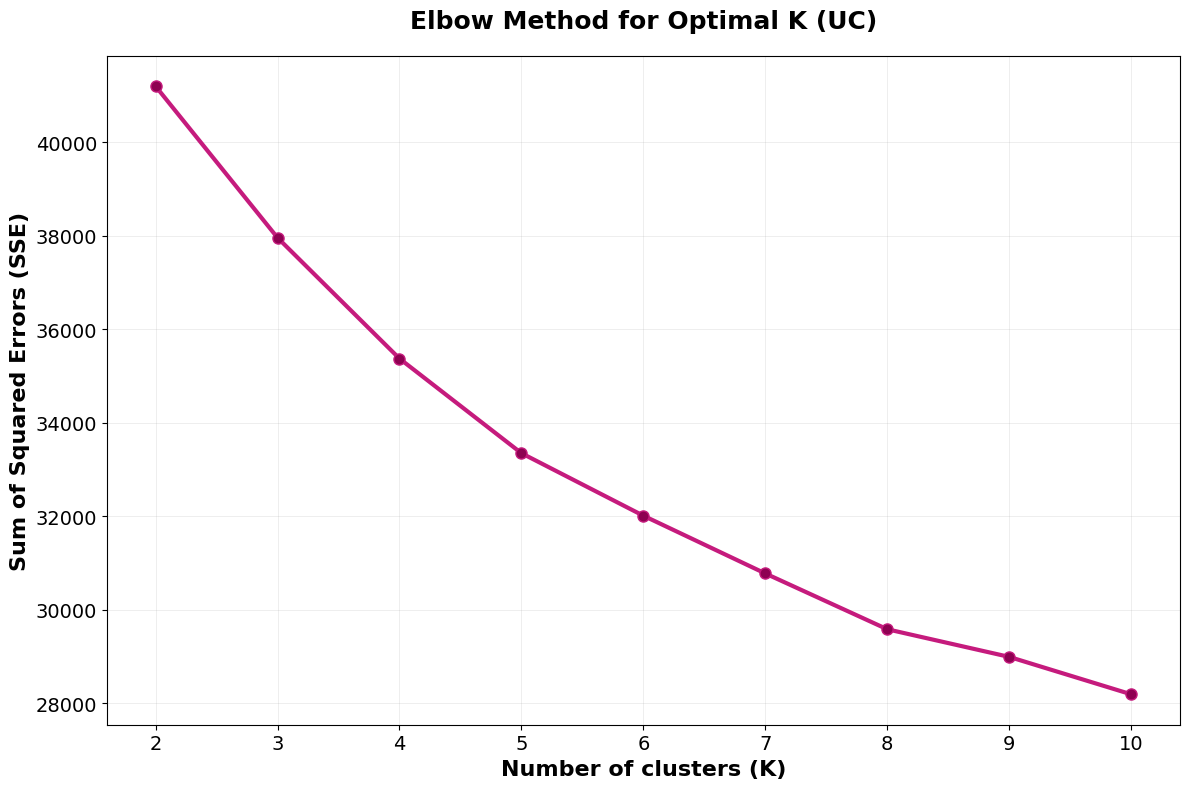

Look for an 'elbow' in the plot.
------------------------------

--- Silhouette Analysis for Optimal K (UC Subtypes) ---
Silhouette Score for K=2 (UC subtypes): 0.3124
Silhouette Score for K=3 (UC subtypes): 0.1318
Silhouette Score for K=4 (UC subtypes): 0.1265
Silhouette Score for K=5 (UC subtypes): 0.1125
Silhouette Score for K=6 (UC subtypes): 0.1173
Silhouette Score for K=7 (UC subtypes): 0.0984
Silhouette Score for K=8 (UC subtypes): 0.1145
Silhouette Score for K=9 (UC subtypes): 0.0833
Silhouette Score for K=10 (UC subtypes): 0.0983


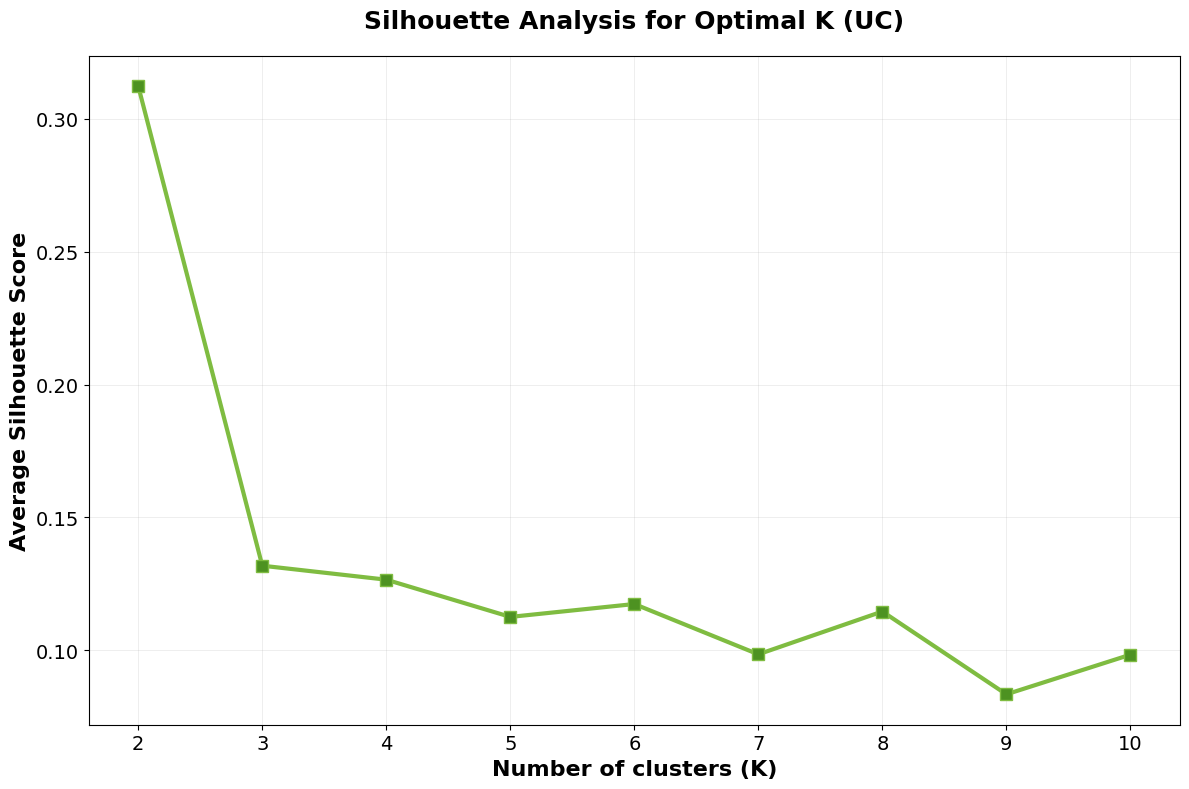

Look for the K that maximizes the Silhouette Score.
------------------------------


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# --- 1. Load the Combined, RedUCed, and Log-Transformed Dataset ---
file_path_redUCed_data = 'processing_data/boruta_filtered_mtb.tsv' 
dataset_name_prefix = 'UC' # For context in outputs

try:
    full_processed_df = pd.read_csv(file_path_redUCed_data, sep='\t')
except FileNotFoundError:
    print(f"Error: The file {file_path_redUCed_data} was not found. Using placeholder.")

print(f"--- K-determination for UC Subtypes from: {file_path_redUCed_data} ---")
print(f"Shape of loaded full dataset: {full_processed_df.shape}")

# --- 2. Filter for UC Patients Only ---
if 'Study.Group' not in full_processed_df.columns:
    print("Error: 'Study.Group' column not found. Cannot filter for UC patients.")
    UC_only_df = pd.DataFrame() # Empty df
else:
    UC_only_df = full_processed_df[full_processed_df['Study.Group'] == 'UC'].copy()

if UC_only_df.empty:
    print("No UC patients found in the dataset. Exiting UC subtype analysis.")
    scaled_features_UC = None
else:
    print(f"Shape of UC-only dataset: {UC_only_df.shape}")

    # --- 3. Prepare Data for Clustering (UC samples) ---
    # Feature columns are all columns except 'Sample' and 'Study.Group'
    feature_columns_UC = [col for col in UC_only_df.columns if col not in ['Sample', 'Study.Group']]

    if not feature_columns_UC:
        print("No feature columns found in UC-only data. Exiting.")
        scaled_features_UC = None 
    else:
        print(f"Identified {len(feature_columns_UC)} feature columns for clustering UC subtypes.")
        features_for_clustering_UC = UC_only_df[feature_columns_UC].copy()

        # Ensures all feature data is numeric
        for col in features_for_clustering_UC.columns: 
            features_for_clustering_UC[col] = pd.to_numeric(features_for_clustering_UC[col], errors='coerce')
        
        features_for_clustering_UC.dropna(axis=1, how='all', inplace=True) # Drop all-NaN columns
        features_for_clustering_UC.dropna(axis=0, how='all', inplace=True) # Drop all-NaN rows
        
        if features_for_clustering_UC.empty or features_for_clustering_UC.shape[1] == 0:
            print("No valid feature data remains after NaN checks for UC samples. Cannot proceed.")
            scaled_features_UC = None
        else:
            print(f"Shape of feature matrix for UC subtype clustering: {features_for_clustering_UC.shape}")
            # Scale the features
            scaler_UC = StandardScaler()
            scaled_features_UC = scaler_UC.fit_transform(features_for_clustering_UC)
            print("UC features standardized for clustering.")
            print("-" * 30)

if scaled_features_UC is not None and scaled_features_UC.shape[0] > 1: # Need at least 2 samples for Kmeans

    colors = ['#8e0152','#c51b7d','#de77ae','#f1b6da','#fde0ef','#e6f5d0','#b8e186','#7fbc41','#4d9221','#276419']

    # --- 4. Determine Optimal K using Elbow Method (for UC subtypes) ---
    print("\n--- Elbow Method for Optimal K (UC Subtypes) ---")
    sse_UC = {} 
    # Adjust k_range if number of UC samples is very small, max K should be < N_samples
    max_k_UC = min(11, scaled_features_UC.shape[0]) # K up to 10 or N_samples_UC-1
    k_range_UC = range(2, max_k_UC) 

    if len(k_range_UC) < 1:
        print(f"Not enough UC samples ({scaled_features_UC.shape[0]}) to test a range of K values >= 2.")
    else:
        for k in k_range_UC:
            kmeans_UC = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=42, algorithm='lloyd')
            kmeans_UC.fit(scaled_features_UC)
            sse_UC[k] = kmeans_UC.inertia_ 
            print(f"SSE for K={k} (UC subtypes): {sse_UC[k]:.2f}")

        plt.figure(figsize=(12, 8))
        plt.plot(list(sse_UC.keys()), list(sse_UC.values()), 
                color=colors[1], marker='o', markersize=8, linewidth=3, markerfacecolor=colors[0])
        plt.xlabel('Number of clusters (K)', fontsize=16, fontweight='bold')
        plt.ylabel('Sum of Squared Errors (SSE)', fontsize=16, fontweight='bold')
        plt.title(f'Elbow Method for Optimal K ({dataset_name_prefix})', fontsize=18, fontweight='bold', pad=20)
        plt.xticks(list(k_range_UC), fontsize=14)
        plt.yticks(fontsize=14)
        plt.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
        plt.tight_layout()
        plt.show()
        print("Look for an 'elbow' in the plot.")
    print("-" * 30)

    # --- 5. Determine Optimal K using Silhouette Analysis (for UC subtypes) ---
    print("\n--- Silhouette Analysis for Optimal K (UC Subtypes) ---")
    silhouette_scores_UC = {}
    if len(k_range_UC) < 1:
        print(f"Not enough UC samples ({scaled_features_UC.shape[0]}) for Silhouette analysis with K >= 2.")
    else:
        for k in k_range_UC: 
            kmeans_UC = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=42, algorithm='lloyd')
            cluster_labels_uc = kmeans_UC.fit_predict(scaled_features_UC)
            try:
                # Ensure there's more than 1 unique label and k < n_samples for silhouette
                if len(np.unique(cluster_labels_uc)) > 1 and len(np.unique(cluster_labels_uc)) < len(scaled_features_UC):
                    silhouette_avg_UC = silhouette_score(scaled_features_UC, cluster_labels_uc)
                    silhouette_scores_UC[k] = silhouette_avg_UC
                    print(f"Silhouette Score for K={k} (UC subtypes): {silhouette_avg_UC:.4f}")
                else:
                    print(f"Could not calculate silhouette score for K={k} (UC subtypes): not enough unique clusters or samples (Unique labels: {len(np.unique(cluster_labels_uc))}, Samples: {len(scaled_features_UC)}).")
                    silhouette_scores_UC[k] = -1 # Invalid score
            except ValueError as e:
                print(f"Could not calculate silhouette score for K={k} (UC subtypes): {e}.")
                silhouette_scores_UC[k] = -1 

        plt.figure(figsize=(12, 8))
        valid_silhouette_k_UC = [k_val for k_val, score in silhouette_scores_UC.items() if score > -1] 
        valid_silhouette_v_UC = [score for k_val, score in silhouette_scores_UC.items() if score > -1]
        
        if valid_silhouette_k_UC:
            plt.plot(valid_silhouette_k_UC, valid_silhouette_v_UC, 
                    color=colors[7], marker='s', markersize=8, linewidth=3, markerfacecolor=colors[8])
            plt.xlabel('Number of clusters (K)', fontsize=16, fontweight='bold')
            plt.ylabel('Average Silhouette Score', fontsize=16, fontweight='bold')
            plt.title(f'Silhouette Analysis for Optimal K ({dataset_name_prefix})', fontsize=18, fontweight='bold', pad=20)
            plt.xticks(valid_silhouette_k_UC, fontsize=14)
            plt.yticks(fontsize=14)
            plt.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
            plt.tight_layout()
            plt.show()
            print("Look for the K that maximizes the Silhouette Score.")
        else:
            print("Could not plot silhouette scores as none were successfully computed for UC subtypes.")
    print("-" * 30)
else:
    print(f"K-determination for UC subtypes skipped as no valid feature data was available for UC samples.")

# CD - K-Means and Hierarchical Clustering

Successfully loaded data from: processing_data/boruta_filtered_mtb.tsv
--- K-means & Hierarchical Clustering for CD Subtypes ---
Shape of CD-only dataset: (155, 615)
Using 613 features for clustering 155 CD samples.
------------------------------

--- Applying K-means with K = 2 for CD Subtypes ---
Silhouette Score for K-means K=2 (CD subtypes): 0.3338
------------------------------

--- CD Subtype K-means Cluster Characterization ---
Value counts for K-means CD Subtype Clusters (K=2):
KMeans_Cluster
0    108
1     47
Name: count, dtype: int64
------------------------------

--- Visualizing CD Subtype K-means Clusters with PCA ---


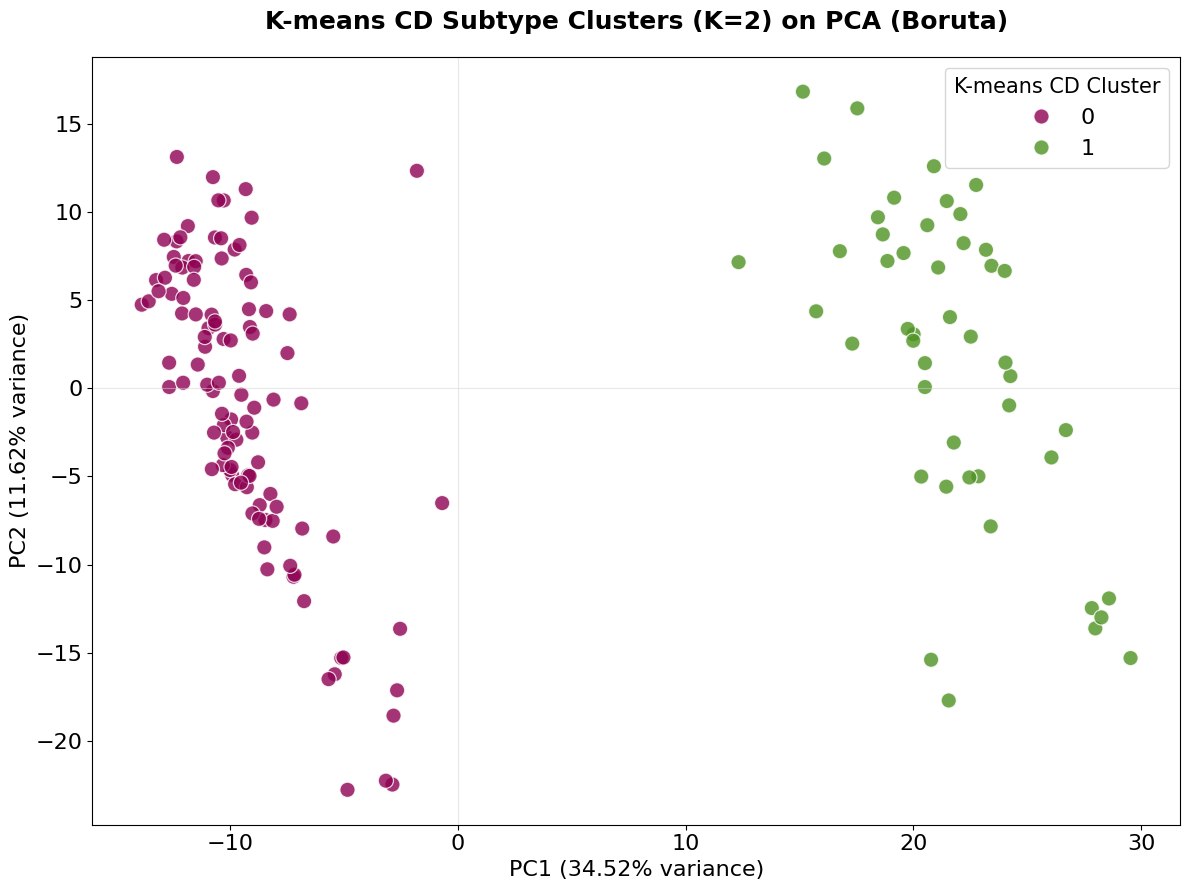

------------------------------
Saved CD data with K-means cluster labels to processing_data/CD_kmeans_2_clustered_data.tsv
------------------------------

--- Hierarchical Clustering for CD Subtypes ---
Performing hierarchical clustering using 'ward' linkage and 'euclidean' metric...


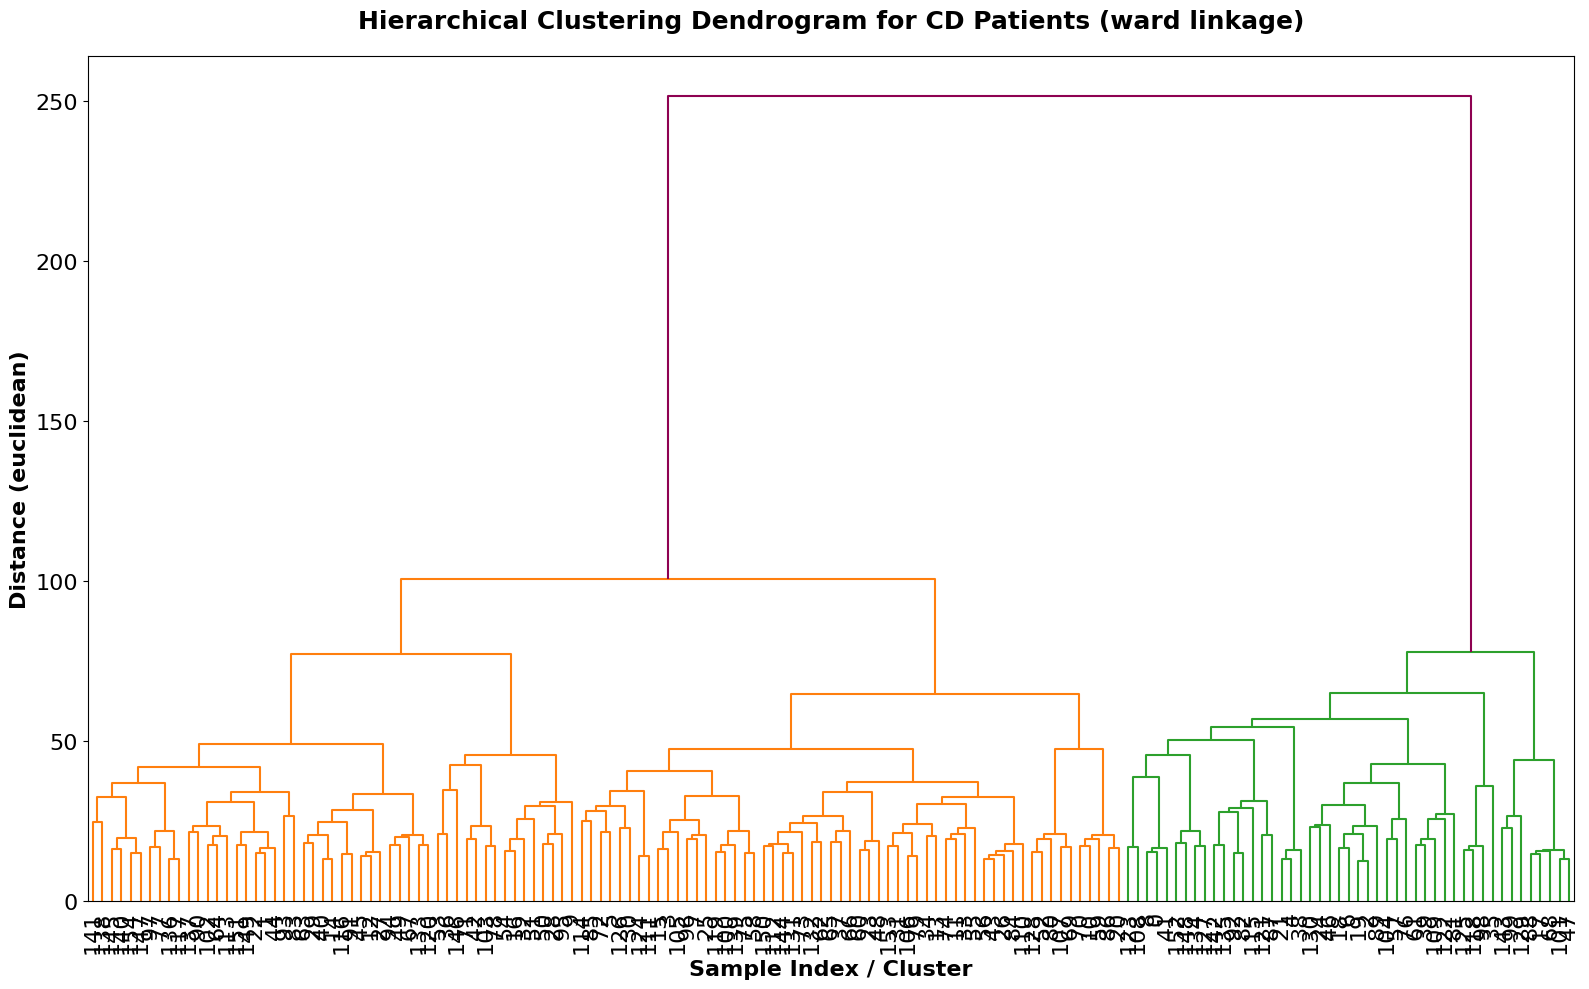

Cutting dendrogram to obtain 2 clusters...

--- CD Subtype Hierarchical Cluster Characterization ---
Value counts for Hierarchical CD Subtype Clusters (K=2):
Hierarchical_Cluster
1     47
2    108
Name: count, dtype: int64
Silhouette Score for Hierarchical Clustering (K=2, CD): 0.3338
------------------------------

--- Visualizing CD Subtype Hierarchical Clusters with PCA ---


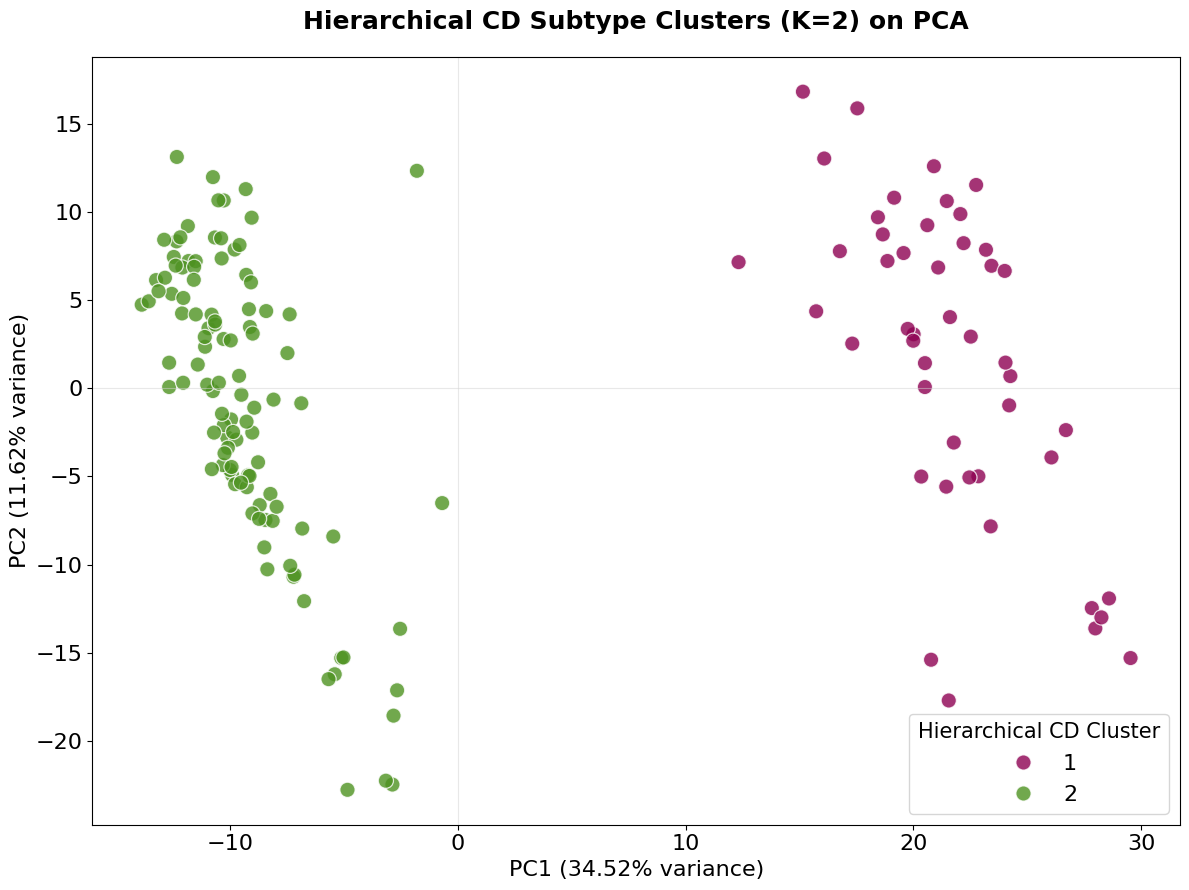

------------------------------

--- Generating Clustermap for CD Subtypes (Hierarchical Clustering) ---
Generating clustermap with 155 samples and 613 features.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


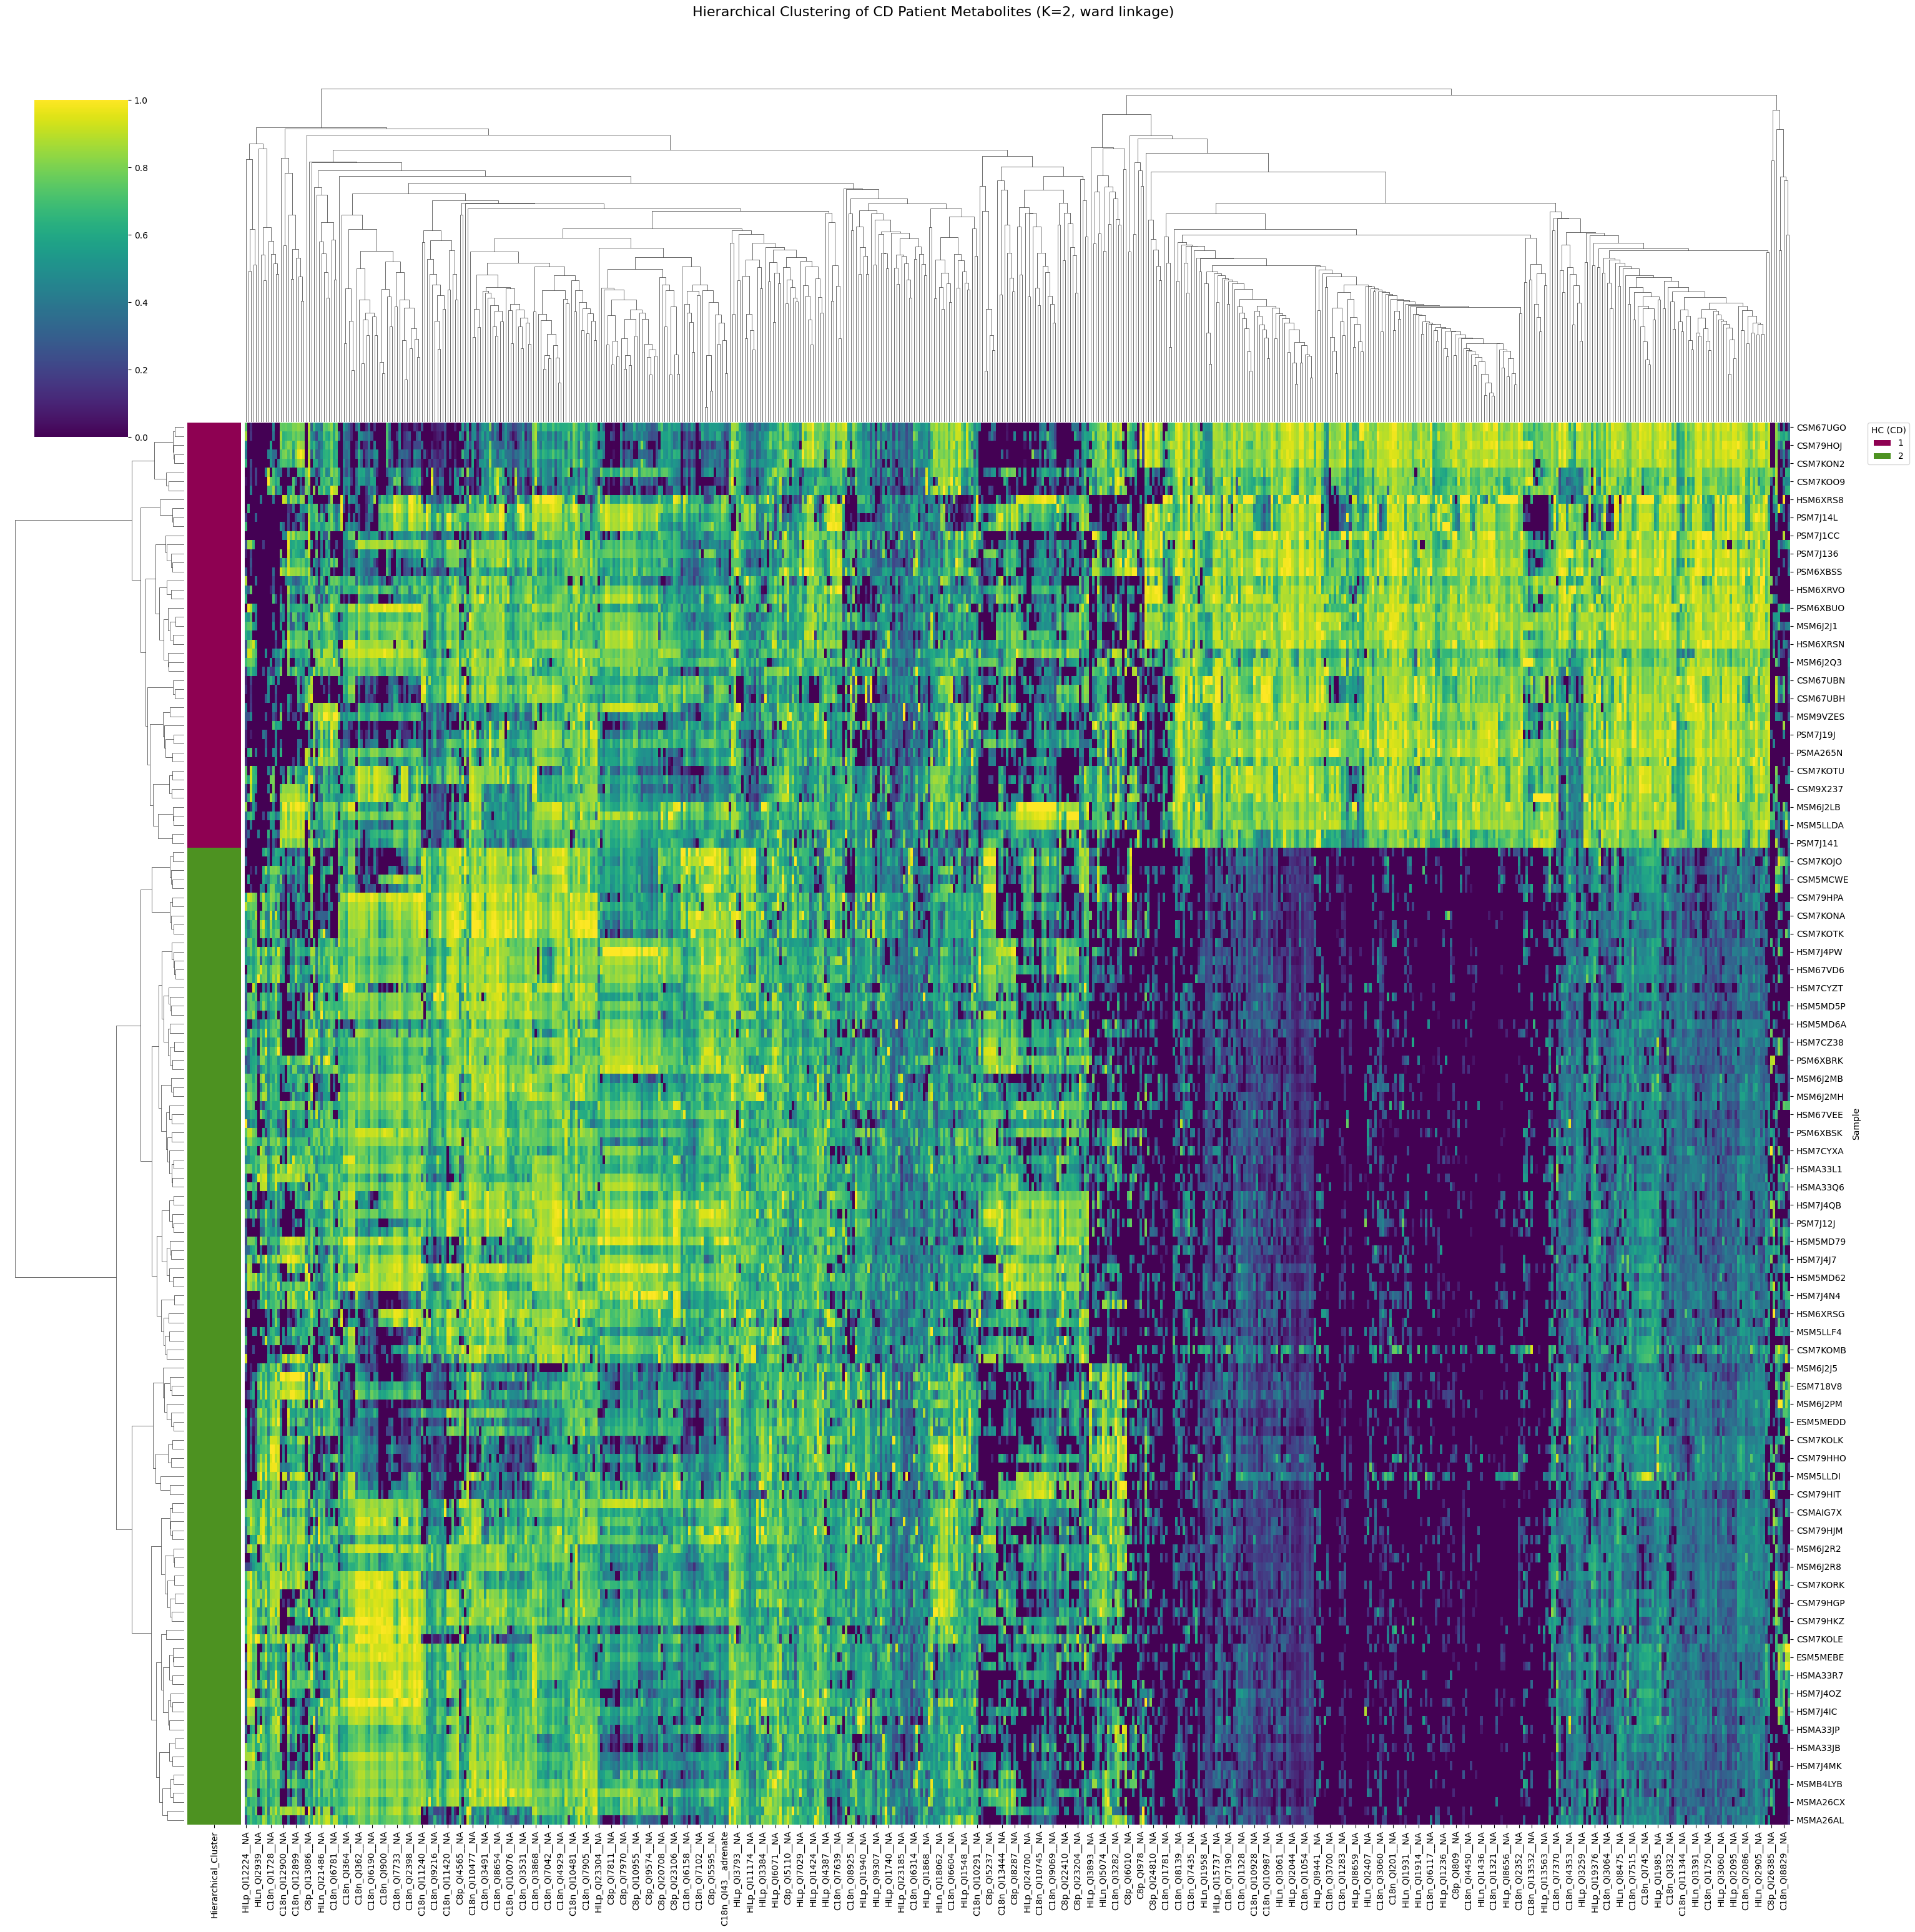

------------------------------
Saved CD data with Hierarchical cluster labels to processing_data/CD_hierarchical_clustered_data.tsv
------------------------------

--- Analysis complete for CD ---


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# --- Libraries for Hierarchical Clustering ---
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from matplotlib.patches import Patch # For custom legends in clustermap

colors = ['#8e0152', '#4d9221']  # Dark pink and dark green

# --- 1. Load the Combined, Reduced, and Log-Transformed Dataset ---
file_path_reduced_data = 'processing_data/boruta_filtered_mtb.tsv'
dataset_name_prefix = 'CD'

try:
    full_processed_df = pd.read_csv(file_path_reduced_data, sep='\t')
    print(f"Successfully loaded data from: {file_path_reduced_data}")
except FileNotFoundError:
    print(f"Error: The file {file_path_reduced_data} was not found. Exiting.")
    exit()

print(f"--- K-means & Hierarchical Clustering for {dataset_name_prefix} Subtypes ---")

# --- 2. Filter for Specific Patient Group (e.g., CD Patients Only) ---
if 'Study.Group' not in full_processed_df.columns:
    print("Error: 'Study.Group' column not found. Cannot filter for patient group.")
    specific_group_df = pd.DataFrame()
else:
    # This makes the script flexible for 'CD' or 'UC' by changing dataset_name_prefix
    specific_group_df = full_processed_df[full_processed_df['Study.Group'] == dataset_name_prefix].copy()

if specific_group_df.empty or len(specific_group_df) < 2 : # Need at least 2 samples for clustering
    print(f"Not enough {dataset_name_prefix} patients found or remaining for subtype analysis (found {len(specific_group_df)}). Exiting.")
    scaled_features_group = None
else:
    print(f"Shape of {dataset_name_prefix}-only dataset: {specific_group_df.shape}")
    feature_columns_group = [col for col in specific_group_df.columns if col not in ['Sample', 'Study.Group']]

    if not feature_columns_group:
        print(f"No feature columns found in {dataset_name_prefix}-only data.")
        scaled_features_group = None
    else:
        # This df holds the original (log-transformed, Boruta-selected) feature values for the group
        features_for_clustering_group = specific_group_df[feature_columns_group].copy()
        
        # Ensure all feature data is numeric (it should be, but good check)
        for col in features_for_clustering_group.columns:
            features_for_clustering_group[col] = pd.to_numeric(features_for_clustering_group[col], errors='coerce')
        # Drop columns/rows that might have become all NaNs after coercion (unlikely with prior processing)
        features_for_clustering_group.dropna(axis=1, how='all', inplace=True)
        # Keep track of original indices to align 'Sample' IDs later
        original_indices_group = features_for_clustering_group.index 
        features_for_clustering_group.dropna(axis=0, how='any', inplace=True) # Drop rows with any NaNs in features
        
        # Align the specific_group_df (metadata) to match exactly the rows used for clustering
        # This df contains 'Sample', 'Study.Group' and will store cluster labels
        group_df_aligned = specific_group_df.loc[features_for_clustering_group.index].copy()

        if features_for_clustering_group.empty or features_for_clustering_group.shape[1] == 0:
            print(f"No valid feature data remains after NaN checks for {dataset_name_prefix} samples.")
            scaled_features_group = None
        elif features_for_clustering_group.shape[0] < 2:
            print(f"Not enough samples ({features_for_clustering_group.shape[0]}) remaining after NaN checks for {dataset_name_prefix} samples.")
            scaled_features_group = None
        else:
            scaler_group = StandardScaler()
            scaled_features_group = scaler_group.fit_transform(features_for_clustering_group)
            print(f"Using {scaled_features_group.shape[1]} features for clustering {scaled_features_group.shape[0]} {dataset_name_prefix} samples.")
            print("-" * 30)

# Proceed only if we have valid scaled features for the group
if scaled_features_group is not None and scaled_features_group.shape[0] > 1:

    # --- 3. Apply K-means Clustering (as per your existing script) ---
    chosen_k_kmeans = 2
    
    if chosen_k_kmeans >= scaled_features_group.shape[0]:
        print(f"Warning: chosen_k_kmeans ({chosen_k_kmeans}) is >= number of samples ({scaled_features_group.shape[0]}). Adjust K.")
    
    print(f"\n--- Applying K-means with K = {chosen_k_kmeans} for {dataset_name_prefix} Subtypes ---")

    kmeans_group = KMeans(n_clusters=chosen_k_kmeans, init='k-means++', max_iter=300, n_init=10, random_state=42, algorithm='lloyd')
    cluster_labels_kmeans_group = kmeans_group.fit_predict(scaled_features_group)

    # Adding K-means cluster labels to the aligned group DataFrame
    group_clustered_df_kmeans = group_df_aligned.copy()
    group_clustered_df_kmeans['KMeans_Cluster'] = cluster_labels_kmeans_group
    
    try:
        # Silhouette score requires at least 2 clusters and less clusters than samples.
        if 1 < len(np.unique(cluster_labels_kmeans_group)) < scaled_features_group.shape[0]:
            current_silhouette_score_kmeans = silhouette_score(scaled_features_group, cluster_labels_kmeans_group)
            print(f"Silhouette Score for K-means K={chosen_k_kmeans} ({dataset_name_prefix} subtypes): {current_silhouette_score_kmeans:.4f}")
        else:
            print(f"Could not calculate silhouette score for K-means K={chosen_k_kmeans} ({dataset_name_prefix} subtypes): "
                  f"Number of unique labels ({len(np.unique(cluster_labels_kmeans_group))}) is not valid for the number of samples ({scaled_features_group.shape[0]}).")
    except ValueError as e:
         print(f"Could not calculate silhouette score for K-means K={chosen_k_kmeans} ({dataset_name_prefix} subtypes): {e}")
    print("-" * 30)

    # --- 4. Characterize K-means Clusters Numerically ---
    print(f"\n--- {dataset_name_prefix} Subtype K-means Cluster Characterization ---")
    print(f"Value counts for K-means {dataset_name_prefix} Subtype Clusters (K={chosen_k_kmeans}):")
    print(group_clustered_df_kmeans['KMeans_Cluster'].value_counts().sort_index())
    print("-" * 30)

    # --- 5. Visualize K-means Clusters using PCA ---
    print(f"\n--- Visualizing {dataset_name_prefix} Subtype K-means Clusters with PCA ---")
    # PCA needs at least 2 components and n_samples >= n_components
    if scaled_features_group.shape[1] >= 2 and scaled_features_group.shape[0] >= 2:
        pca_for_group_viz = PCA(n_components=2, random_state=42)
        principal_components_group_viz = pca_for_group_viz.fit_transform(scaled_features_group)
        
        pca_group_viz_df = pd.DataFrame(
            data=principal_components_group_viz,
            columns=[f'PC1_{dataset_name_prefix}_Subtype', f'PC2_{dataset_name_prefix}_Subtype'],
            index=group_clustered_df_kmeans.index # Use index from the clustered_df for correct alignment
        )
        
        # Combine PCA results with KMeans_Cluster labels and Sample IDs
        pca_group_viz_df = pd.concat([pca_group_viz_df, group_clustered_df_kmeans[['Sample', 'KMeans_Cluster']]], axis=1)

        plt.figure(figsize=(12, 9))
        sns.scatterplot(
            x=f'PC1_{dataset_name_prefix}_Subtype',
            y=f'PC2_{dataset_name_prefix}_Subtype',
            hue='KMeans_Cluster',
            palette=(colors * (chosen_k_kmeans // 2 + 1))[:chosen_k_kmeans],
            data=pca_group_viz_df,
            s=120,
            alpha=0.8
        )
        plt.title(f'K-means {dataset_name_prefix} Subtype Clusters (K={chosen_k_kmeans}) on PCA (Boruta)', 
                  fontsize=18, fontweight='semibold', pad=20)
        plt.xlabel(f'PC1 ({pca_for_group_viz.explained_variance_ratio_[0]:.2%} variance)', 
                   fontsize=16, fontweight='regular')
        plt.ylabel(f'PC2 ({pca_for_group_viz.explained_variance_ratio_[1]:.2%} variance)', 
                   fontsize=16, fontweight='regular')
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        legend = plt.legend(title=f'K-means {dataset_name_prefix} Cluster', fontsize=16, title_fontsize=16)
        legend.set_title(f'K-means {dataset_name_prefix} Cluster', prop={'size': 15, 'weight': 'regular'})
        plt.grid(False)
        plt.axhline(0, color='lightgrey', lw=0.8, alpha=0.5)
        plt.axvline(0, color='lightgrey', lw=0.8, alpha=0.5)
        plt.tight_layout()
        plt.show()
    else:
        print(f"Not enough features/samples for PCA plot for {dataset_name_prefix} K-means subtypes.")
    print("-" * 30)

    # --- Save K-means clustered data ---
    output_filename_kmeans = f'processing_data/{dataset_name_prefix}_kmeans_2_clustered_data.tsv'
    group_clustered_df_kmeans.to_csv(output_filename_kmeans, sep='\t', index=False)
    print(f"Saved {dataset_name_prefix} data with K-means cluster labels to {output_filename_kmeans}")
    print("-" * 30)


    ###########################################################################
    # --- Hierarchical Clustering for CD (or specified group) Subtypes ---
    ###########################################################################
    print(f"\n--- Hierarchical Clustering for {dataset_name_prefix} Subtypes ---")

    # --- 6. Perform Hierarchical Clustering ---
    # Choose linkage method and metric
    linkage_method = 'ward'  # Minimizes variance within clusters, good for general purpose
    metric = 'euclidean'     # Standard for scaled data with 'ward'

    print(f"Performing hierarchical clustering using '{linkage_method}' linkage and '{metric}' metric...")
    # `scaled_features_group` is the Z-scaled feature matrix for CD patients
    linked_matrix = linkage(scaled_features_group, method=linkage_method, metric=metric)

    # --- 7. Plot the Dendrogram ---
    plt.figure(figsize=(16, 10))
    dendrogram(linked_matrix,
               orientation='top',
               distance_sort='descending',
               show_leaf_counts=True,
               truncate_mode=None, 
               color_threshold=0.7*max(linked_matrix[:,2]),
               above_threshold_color=colors[0]) # dark pink for branches above threshold
    plt.title(f'Hierarchical Clustering Dendrogram for {dataset_name_prefix} Patients ({linkage_method} linkage)', 
              fontsize=18, fontweight='semibold', pad=20)
    plt.xlabel("Sample Index / Cluster", fontsize=16, fontweight='semibold')
    plt.ylabel(f"Distance ({metric})", fontsize=16, fontweight='semibold')
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.tight_layout()
    plt.show()

    # --- 8. Determine Clusters from Dendrogram & Assign Labels ---
    num_clusters_hc = chosen_k_kmeans
    
    if num_clusters_hc >= scaled_features_group.shape[0] :
        print(f"Warning: num_clusters_hc ({num_clusters_hc}) is >= number of samples ({scaled_features_group.shape[0]}). Adjust K_hc.")
        if scaled_features_group.shape[0] > 1:
            num_clusters_hc = max(2, scaled_features_group.shape[0] -1) # Ensures at least 2 clusters if possible
            print(f"Adjusted num_clusters_hc to {num_clusters_hc}")
        else: # Should not happen at this point
             print(f"Cannot perform hierarchical clustering with {scaled_features_group.shape[0]} samples.")
             # Skip further HC steps if this edge case is hit
             num_clusters_hc = 0


    if num_clusters_hc > 0: # Proceed if num_clusters_hc is valid
        print(f"Cutting dendrogram to obtain {num_clusters_hc} clusters...")
        cluster_labels_hc_group = fcluster(linked_matrix, num_clusters_hc, criterion='maxclust')

        # Add Hierarchical Cluster labels to a new DataFrame
        group_clustered_df_hc = group_df_aligned.copy() # Starts with the same aligned group data
        group_clustered_df_hc['Hierarchical_Cluster'] = cluster_labels_hc_group
        
        # --- 9. Characterize Hierarchical Clusters ---
        print(f"\n--- {dataset_name_prefix} Subtype Hierarchical Cluster Characterization ---")
        print(f"Value counts for Hierarchical {dataset_name_prefix} Subtype Clusters (K={num_clusters_hc}):")
        print(group_clustered_df_hc['Hierarchical_Cluster'].value_counts().sort_index())

        try:
            if 1 < len(np.unique(cluster_labels_hc_group)) < scaled_features_group.shape[0]:
                silhouette_avg_hc = silhouette_score(scaled_features_group, cluster_labels_hc_group)
                print(f"Silhouette Score for Hierarchical Clustering (K={num_clusters_hc}, {dataset_name_prefix}): {silhouette_avg_hc:.4f}")
            else:
                print(f"Could not calculate silhouette score for Hierarchical Clustering (K={num_clusters_hc}, {dataset_name_prefix}): "
                      f"Number of unique labels ({len(np.unique(cluster_labels_hc_group))}) is not valid for the number of samples ({scaled_features_group.shape[0]}).")
        except ValueError as e:
            print(f"Could not calculate silhouette score for Hierarchical Clustering (K={num_clusters_hc}, {dataset_name_prefix}): {e}")
        print("-" * 30)

        # --- 10. Visualize Hierarchical Clusters using PCA (for comparison with K-means) ---
        print(f"\n--- Visualizing {dataset_name_prefix} Subtype Hierarchical Clusters with PCA ---")
        if 'pca_for_group_viz' in locals() and pca_for_group_viz is not None:
            pca_group_viz_df_hc = pd.DataFrame(
                data=principal_components_group_viz,
                columns=[f'PC1_{dataset_name_prefix}_Subtype', f'PC2_{dataset_name_prefix}_Subtype'],
                index=group_clustered_df_hc.index
            )
            pca_group_viz_df_hc = pd.concat([pca_group_viz_df_hc, group_clustered_df_hc[['Sample', 'Hierarchical_Cluster']]], axis=1)
            plt.figure(figsize=(12, 9))
            sns.scatterplot(
                x=f'PC1_{dataset_name_prefix}_Subtype',
                y=f'PC2_{dataset_name_prefix}_Subtype',
                hue='Hierarchical_Cluster',
                palette=(colors * (num_clusters_hc // 2 + 1))[:num_clusters_hc],
                data=pca_group_viz_df_hc,
                s=120,
                alpha=0.8
            )
            plt.title(f'Hierarchical {dataset_name_prefix} Subtype Clusters (K={num_clusters_hc}) on PCA', 
                      fontsize=18, fontweight='semibold', pad=20)
            plt.xlabel(f'PC1 ({pca_for_group_viz.explained_variance_ratio_[0]:.2%} variance)', 
                       fontsize=16, fontweight='regular')
            plt.ylabel(f'PC2 ({pca_for_group_viz.explained_variance_ratio_[1]:.2%} variance)', 
                       fontsize=16, fontweight='regular')
            plt.xticks(fontsize=16)
            plt.yticks(fontsize=16)
            legend = plt.legend(title=f'Hierarchical {dataset_name_prefix} Cluster', fontsize=16, title_fontsize=16)
            legend.set_title(f'Hierarchical {dataset_name_prefix} Cluster', prop={'size': 15, 'weight': 'regular'})
            plt.grid(False)
            plt.axhline(0, color='lightgrey', lw=0.8, alpha=0.5)
            plt.axvline(0, color='lightgrey', lw=0.8, alpha=0.5)
            plt.tight_layout()
            plt.show()
        else:
            print(f"PCA components not available for visualizing Hierarchical clusters for {dataset_name_prefix}.")
        print("-" * 30)

        # --- 11. Visualize with Clustermap (Heatmap with Dendrograms) ---
        print(f"\n--- Generating Clustermap for {dataset_name_prefix} Subtypes (Hierarchical Clustering) ---")
        
        data_for_heatmap_group = features_for_clustering_group.copy()
        # Set Sample IDs as index if they are not already - should be (for labeling heatmap rows)
        if 'Sample' in group_df_aligned.columns:
             data_for_heatmap_group.index = group_df_aligned['Sample']
        
        # Create a Series for row colors based on hierarchical cluster, indexed by Sample ID
        cluster_series_hc = group_clustered_df_hc.set_index('Sample')['Hierarchical_Cluster']
        
        unique_hc_clusters = sorted(cluster_series_hc.unique())
        palette_hc_map = (colors * (len(unique_hc_clusters) // 2 + 1))[:len(unique_hc_clusters)]
        cluster_color_map_hc = {cluster_val: color for cluster_val, color in zip(unique_hc_clusters, palette_hc_map)}
        row_colors_hc_mapped = cluster_series_hc.map(cluster_color_map_hc)
        
        # This should be fine because both used 'Sample' as index from group_df_aligned/group_clustered_df_hc
        if not data_for_heatmap_group.index.equals(row_colors_hc_mapped.index):
            print("Warning: Index mismatch between heatmap data and row colors. Attempting to align.")
            try:
                row_colors_hc_mapped = row_colors_hc_mapped.reindex(data_for_heatmap_group.index)
            except Exception as e:
                print(f"Could not align row_colors with heatmap data: {e}. Clustermap might not have row colors.")


        if data_for_heatmap_group.shape[0] > 1 and data_for_heatmap_group.shape[1] > 1:
            print(f"Generating clustermap with {data_for_heatmap_group.shape[0]} samples and {data_for_heatmap_group.shape[1]} features.")
            try:
                g = sns.clustermap(
                    data_for_heatmap_group,      # Original selected features (log-transformed)
                    row_linkage=linked_matrix,   # Use pre-computed linkage for rows (samples)
                    cmap="viridis",
                    standard_scale=1,            # Z-score features (columns) for visualization
                    row_colors=row_colors_hc_mapped if not row_colors_hc_mapped.isnull().all() else None,
                    figsize=(min(30, 0.8 * data_for_heatmap_group.shape[1]), # Width based on num features
                             min(30, 0.4 * data_for_heatmap_group.shape[0] + 5)), # Height based on num samples
                    dendrogram_ratio=(.1, .2)
                )
                g.fig.suptitle(f'Hierarchical Clustering of {dataset_name_prefix} Patient Metabolites (K={num_clusters_hc}, {linkage_method} linkage)', y=1.03, fontsize=16)
                if not row_colors_hc_mapped.isnull().all():
                    handles = [Patch(facecolor=cluster_color_map_hc[name]) for name in unique_hc_clusters if name in cluster_color_map_hc]
                    if handles: # only add legend if there are handles
                        # Position legend outside, adjust bbox_to_anchor and loc as needed
                        legend_title = f'HC ({dataset_name_prefix})'
                        g.ax_heatmap.legend(handles, unique_hc_clusters, title=legend_title,
                                            bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
                plt.show()
            except Exception as e:
                print(f"Error generating clustermap: {e}")
                print("This can happen if there are too few samples/features or issues with linkage/data.")

        else:
            print(f"Not enough samples or features for Clustermap for {dataset_name_prefix} subtypes.")
        print("-" * 30)

        # --- 12. Save DataFrame with Hierarchical Cluster labels ---
        output_filename_hc = f'processing_data/{dataset_name_prefix}_hierarchical_clustered_data.tsv'
        group_clustered_df_hc.to_csv(output_filename_hc, sep='\t', index=False)
        print(f"Saved {dataset_name_prefix} data with Hierarchical cluster labels to {output_filename_hc}")
        print("-" * 30)
    else:
        print(f"Hierarchical clustering skipped for {dataset_name_prefix} due to invalid number of clusters ({num_clusters_hc}).")


else:
    print(f"K-means and Hierarchical clustering for {dataset_name_prefix} subtypes skipped as no valid feature data was available or insufficient samples.")

print(f"\n--- Analysis complete for {dataset_name_prefix} ---")

# UC - K-Means and Hierarchical Clustering

Successfully loaded data from: processing_data/boruta_filtered_mtb.tsv
--- K-means & Hierarchical Clustering for UC Subtypes ---
Shape of UC-only dataset: (96, 615)
Using 613 features for clustering 96 UC samples.
------------------------------

--- Applying K-means with K = 2 for UC Subtypes ---
Silhouette Score for K-means K=2 (UC subtypes): 0.3124
------------------------------

--- UC Subtype K-means Cluster Characterization ---
Value counts for K-means UC Subtype Clusters (K=2):
KMeans_Cluster
0    70
1    26
Name: count, dtype: int64
------------------------------

--- Visualizing UC Subtype K-means Clusters with PCA ---


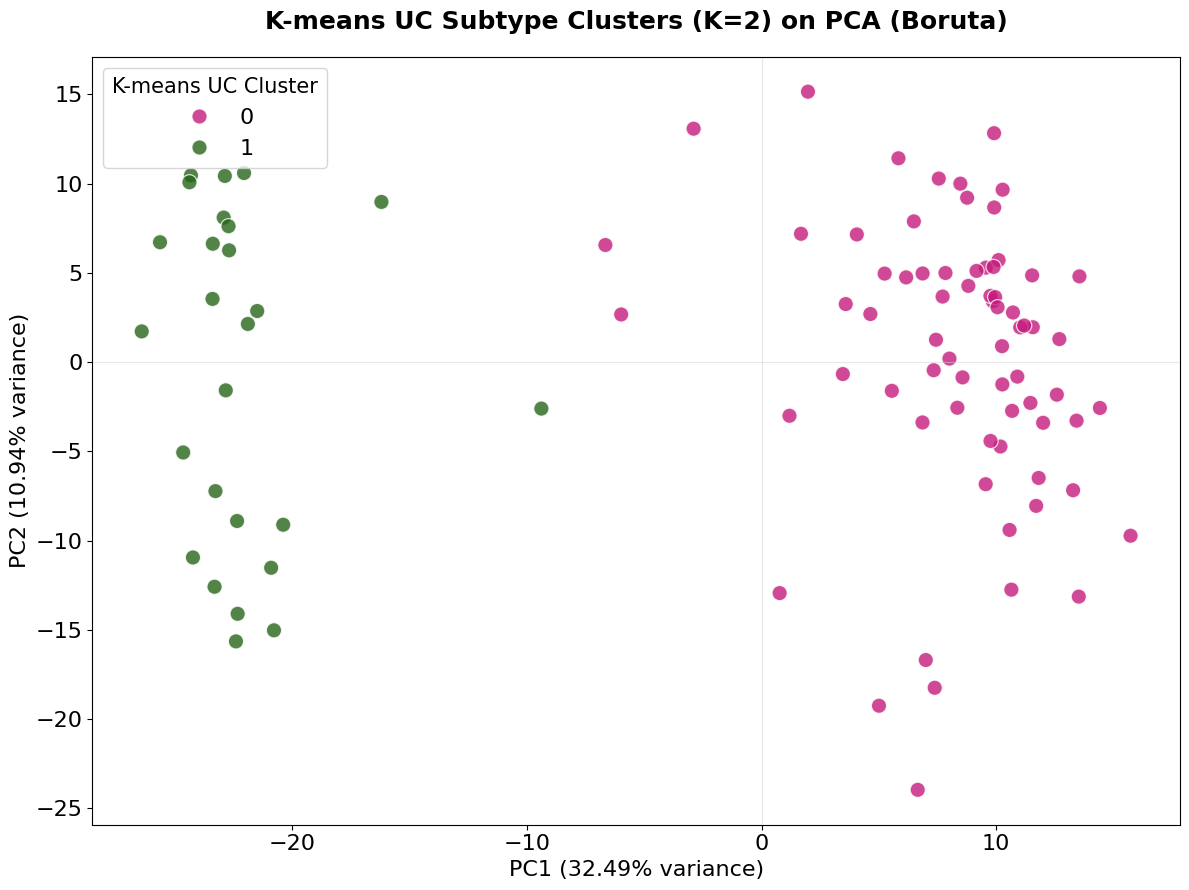

------------------------------
Saved UC data with K-means cluster labels to processing_data/UC_kmeans_2_clustered_data.tsv
------------------------------

--- Hierarchical Clustering for UC Subtypes ---
Performing hierarchical clustering using 'ward' linkage and 'euclidean' metric...


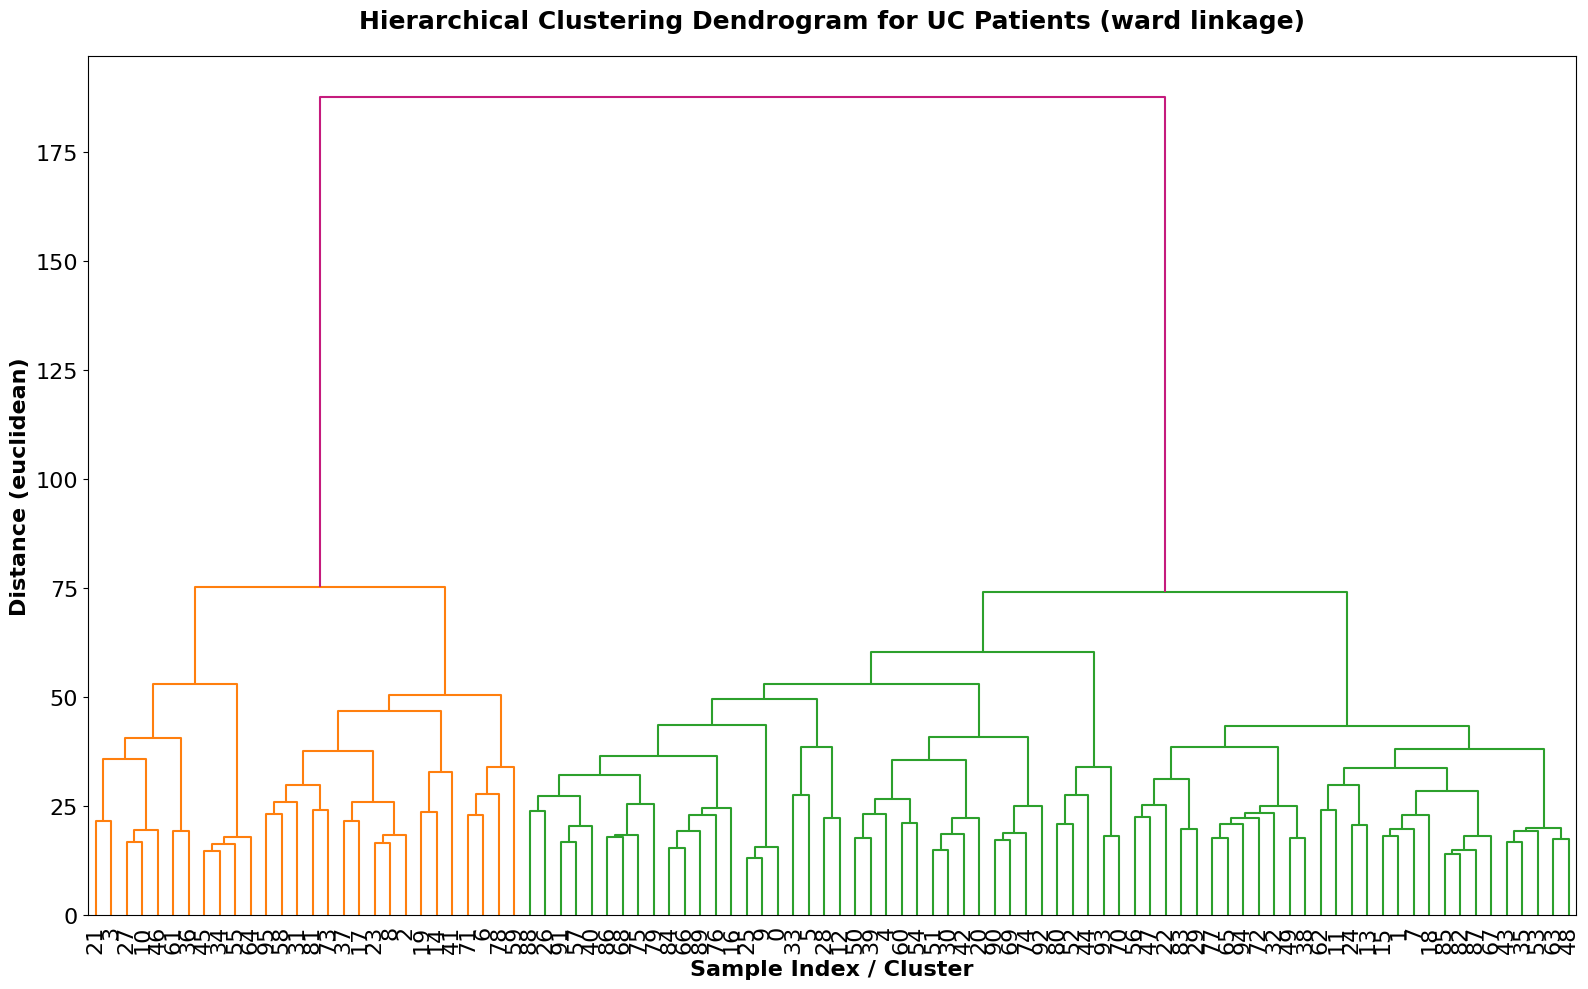

Cutting dendrogram to obtain 2 clusters...

--- UC Subtype Hierarchical Cluster Characterization ---
Value counts for Hierarchical UC Subtype Clusters (K=2):
Hierarchical_Cluster
1    68
2    28
Name: count, dtype: int64
Silhouette Score for Hierarchical Clustering (K=2, UC): 0.3021
------------------------------

--- Visualizing UC Subtype Hierarchical Clusters with PCA ---


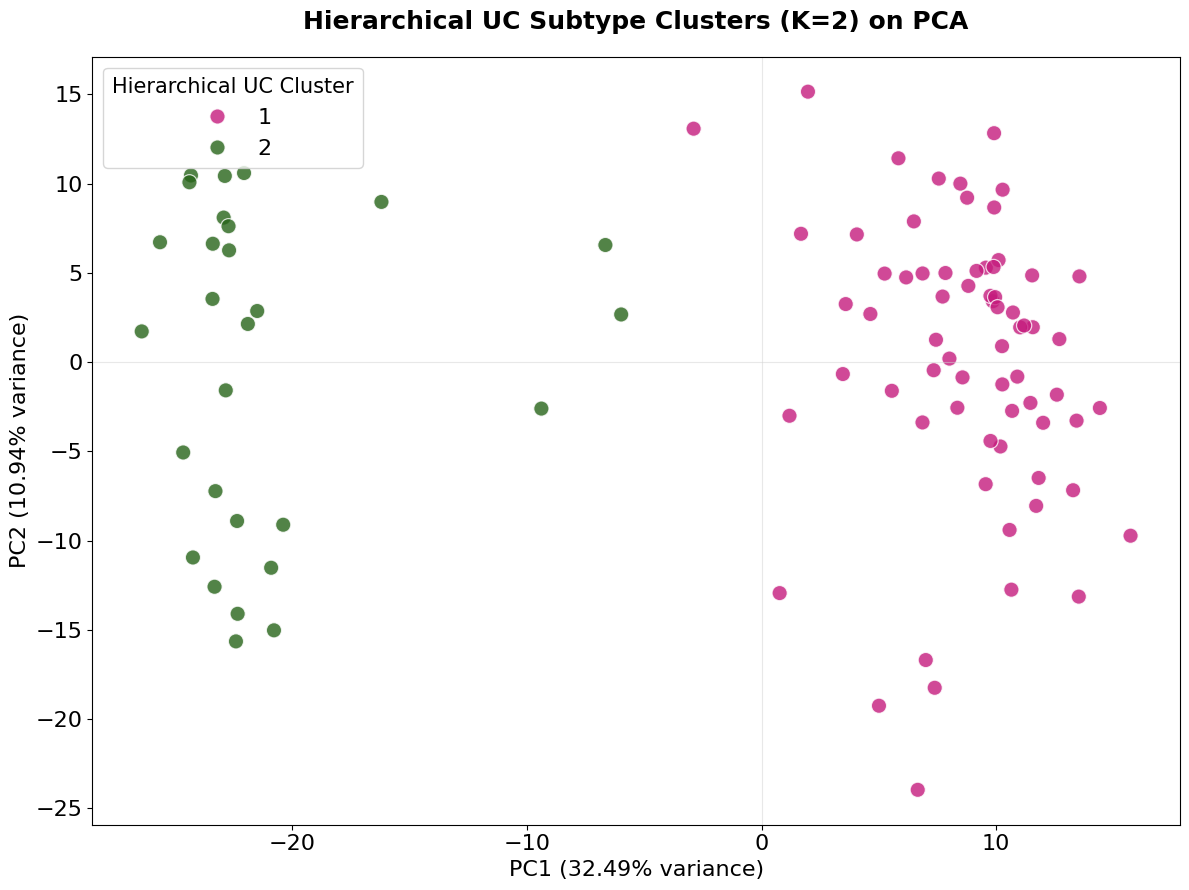

------------------------------

--- Generating Clustermap for UC Subtypes (Hierarchical Clustering) ---
Generating clustermap with 96 samples and 613 features.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


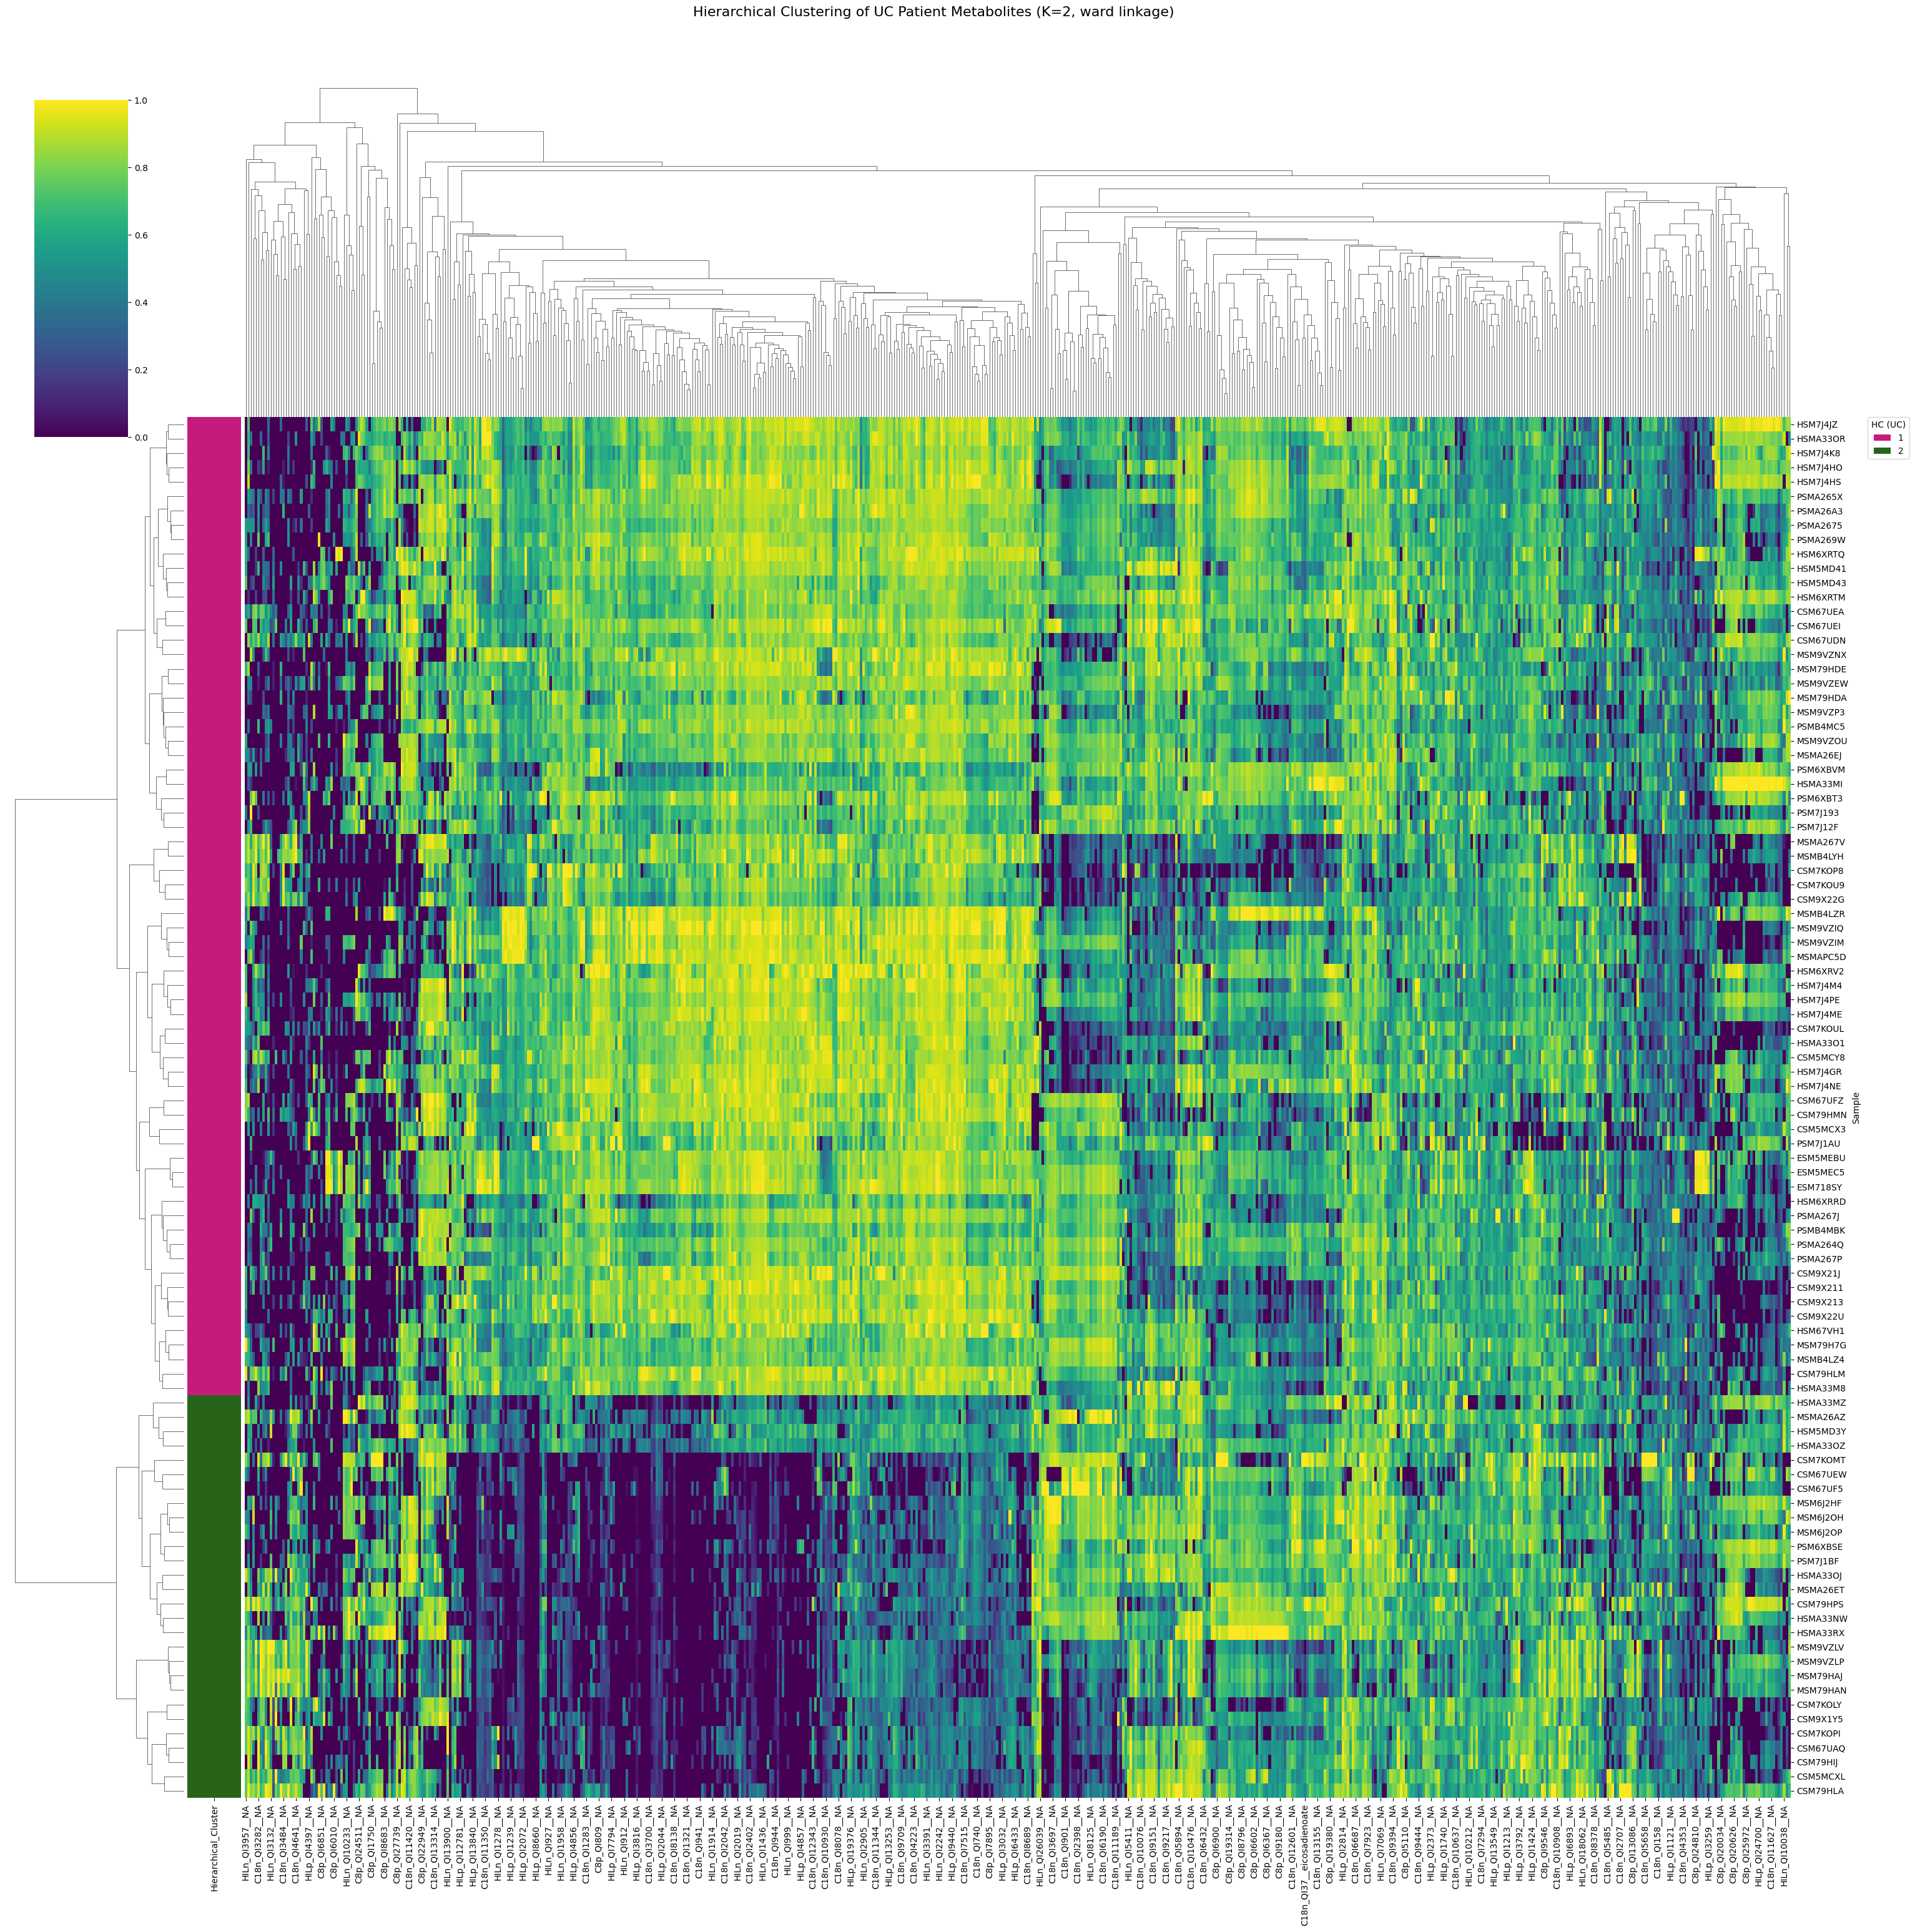

------------------------------
Saved UC data with Hierarchical cluster labels to processing_data/UC_hierarchical_clustered_data.tsv
------------------------------

--- Analysis complete for UC ---


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# --- Libraries for Hierarchical Clustering ---
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from matplotlib.patches import Patch # For custom legends in clustermap

colors = ['#c51b7d', '#276419']  # Dark pink and dark green

# --- 1. Load the Combined, Reduced, and Log-Transformed Dataset ---
file_path_reduced_data = 'processing_data/boruta_filtered_mtb.tsv'
dataset_name_prefix = 'UC' # For context in outputs

try:
    full_processed_df = pd.read_csv(file_path_reduced_data, sep='\t')
    print(f"Successfully loaded data from: {file_path_reduced_data}")
except FileNotFoundError:
    print(f"Error: The file {file_path_reduced_data} was not found. Exiting.")
    exit()

print(f"--- K-means & Hierarchical Clustering for {dataset_name_prefix} Subtypes ---")

# --- 2. Filter for UC Patients Only ---
if 'Study.Group' not in full_processed_df.columns:
    print("Error: 'Study.Group' column not found. Cannot filter for patient group.")
    specific_group_df = pd.DataFrame()
else:
    # This makes the script flexible for 'UC' or 'UC' by changing dataset_name_prefix
    specific_group_df = full_processed_df[full_processed_df['Study.Group'] == dataset_name_prefix].copy()

if specific_group_df.empty or len(specific_group_df) < 2 :
    print(f"Not enough {dataset_name_prefix} patients found or remaining for subtype analysis (found {len(specific_group_df)}). Exiting.")
    scaled_features_group = None
else:
    print(f"Shape of {dataset_name_prefix}-only dataset: {specific_group_df.shape}")
    feature_columns_group = [col for col in specific_group_df.columns if col not in ['Sample', 'Study.Group']]

    if not feature_columns_group:
        print(f"No feature columns found in {dataset_name_prefix}-only data.")
        scaled_features_group = None
    else:
        features_for_clustering_group = specific_group_df[feature_columns_group].copy()
        
        for col in features_for_clustering_group.columns:
            features_for_clustering_group[col] = pd.to_numeric(features_for_clustering_group[col], errors='coerce')
        
        # Drop columns/rows that might have become all NaNs after coercion (unlikely with prior processing)
        features_for_clustering_group.dropna(axis=1, how='all', inplace=True)
        # Keep track of original indices to align 'Sample' IDs later
        original_indices_group = features_for_clustering_group.index 
        features_for_clustering_group.dropna(axis=0, how='any', inplace=True) # Drop rows with any NaNs in features
        
        group_df_aligned = specific_group_df.loc[features_for_clustering_group.index].copy()

        if features_for_clustering_group.empty or features_for_clustering_group.shape[1] == 0:
            print(f"No valid feature data remains after NaN checks for {dataset_name_prefix} samples.")
            scaled_features_group = None
        elif features_for_clustering_group.shape[0] < 2:
            print(f"Not enough samples ({features_for_clustering_group.shape[0]}) remaining after NaN checks for {dataset_name_prefix} samples.")
            scaled_features_group = None
        else:
            scaler_group = StandardScaler()
            scaled_features_group = scaler_group.fit_transform(features_for_clustering_group)
            print(f"Using {scaled_features_group.shape[1]} features for clustering {scaled_features_group.shape[0]} {dataset_name_prefix} samples.")
            print("-" * 30)

# Proceed only if we have valid scaled features for the group
if scaled_features_group is not None and scaled_features_group.shape[0] > 1:

    # --- 3. Apply K-means Clustering (as per your existing script) ---
    chosen_k_kmeans = 2
    
    if chosen_k_kmeans >= scaled_features_group.shape[0]:
        print(f"Warning: chosen_k_kmeans ({chosen_k_kmeans}) is >= number of samples ({scaled_features_group.shape[0]}). Adjust K.")
    
    print(f"\n--- Applying K-means with K = {chosen_k_kmeans} for {dataset_name_prefix} Subtypes ---")

    kmeans_group = KMeans(n_clusters=chosen_k_kmeans, init='k-means++', max_iter=300, n_init=10, random_state=42, algorithm='lloyd')
    cluster_labels_kmeans_group = kmeans_group.fit_predict(scaled_features_group)

    group_clustered_df_kmeans = group_df_aligned.copy()
    group_clustered_df_kmeans['KMeans_Cluster'] = cluster_labels_kmeans_group
    
    try:
        if 1 < len(np.unique(cluster_labels_kmeans_group)) < scaled_features_group.shape[0]:
            current_silhouette_score_kmeans = silhouette_score(scaled_features_group, cluster_labels_kmeans_group)
            print(f"Silhouette Score for K-means K={chosen_k_kmeans} ({dataset_name_prefix} subtypes): {current_silhouette_score_kmeans:.4f}")
        else:
            print(f"Could not calculate silhouette score for K-means K={chosen_k_kmeans} ({dataset_name_prefix} subtypes): "
                  f"Number of unique labels ({len(np.unique(cluster_labels_kmeans_group))}) is not valid for the number of samples ({scaled_features_group.shape[0]}).")
    except ValueError as e:
         print(f"Could not calculate silhouette score for K-means K={chosen_k_kmeans} ({dataset_name_prefix} subtypes): {e}")
    print("-" * 30)

    # --- 4. Characterize K-means Clusters Numerically ---
    print(f"\n--- {dataset_name_prefix} Subtype K-means Cluster Characterization ---")
    print(f"Value counts for K-means {dataset_name_prefix} Subtype Clusters (K={chosen_k_kmeans}):")
    print(group_clustered_df_kmeans['KMeans_Cluster'].value_counts().sort_index())
    print("-" * 30)

    # --- 5. Visualize K-means Clusters using PCA ---
    print(f"\n--- Visualizing {dataset_name_prefix} Subtype K-means Clusters with PCA ---")
    if scaled_features_group.shape[1] >= 2 and scaled_features_group.shape[0] >= 2:
        pca_for_group_viz = PCA(n_components=2, random_state=42)
        principal_components_group_viz = pca_for_group_viz.fit_transform(scaled_features_group)
        
        pca_group_viz_df = pd.DataFrame(
            data=principal_components_group_viz,
            columns=[f'PC1_{dataset_name_prefix}_Subtype', f'PC2_{dataset_name_prefix}_Subtype'],
            index=group_clustered_df_kmeans.index
        )
        
        pca_group_viz_df = pd.concat([pca_group_viz_df, group_clustered_df_kmeans[['Sample', 'KMeans_Cluster']]], axis=1)

        plt.figure(figsize=(12, 9))
        sns.scatterplot(
            x=f'PC1_{dataset_name_prefix}_Subtype',
            y=f'PC2_{dataset_name_prefix}_Subtype',
            hue='KMeans_Cluster',
            palette=(colors * (chosen_k_kmeans // 2 + 1))[:chosen_k_kmeans],
            data=pca_group_viz_df,
            s=120,
            alpha=0.8
        )
        plt.title(f'K-means {dataset_name_prefix} Subtype Clusters (K={chosen_k_kmeans}) on PCA (Boruta)', 
                  fontsize=18, fontweight='semibold', pad=20)
        plt.xlabel(f'PC1 ({pca_for_group_viz.explained_variance_ratio_[0]:.2%} variance)', 
                   fontsize=16, fontweight='regular')
        plt.ylabel(f'PC2 ({pca_for_group_viz.explained_variance_ratio_[1]:.2%} variance)', 
                   fontsize=16, fontweight='regular')
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        legend = plt.legend(title=f'K-means {dataset_name_prefix} Cluster', fontsize=16, title_fontsize=16)
        legend.set_title(f'K-means {dataset_name_prefix} Cluster', prop={'size': 15, 'weight': 'regular'})
        plt.grid(False)
        plt.axhline(0, color='lightgrey', lw=0.8, alpha=0.5)
        plt.axvline(0, color='lightgrey', lw=0.8, alpha=0.5)
        plt.tight_layout()
        plt.show()
    else:
        print(f"Not enough features/samples for PCA plot for {dataset_name_prefix} K-means subtypes.")
    print("-" * 30)

    # --- Save K-means clustered data ---
    output_filename_kmeans = f'processing_data/{dataset_name_prefix}_kmeans_2_clustered_data.tsv'
    group_clustered_df_kmeans.to_csv(output_filename_kmeans, sep='\t', index=False)
    print(f"Saved {dataset_name_prefix} data with K-means cluster labels to {output_filename_kmeans}")
    print("-" * 30)


    ###########################################################################
    # --- Hierarchical Clustering for UC Subtypes ---
    ###########################################################################
    print(f"\n--- Hierarchical Clustering for {dataset_name_prefix} Subtypes ---")

    # --- 6. Perform Hierarchical Clustering ---
    linkage_method = 'ward'  # Minimizes variance within clusters, good for general purpose
    metric = 'euclidean'     # Standard for scaled data with 'ward'

    print(f"Performing hierarchical clustering using '{linkage_method}' linkage and '{metric}' metric...")
    # `scaled_features_group` is the Z-scaled feature matrix for UC patients
    linked_matrix = linkage(scaled_features_group, method=linkage_method, metric=metric)

    # --- 7. Plot the Dendrogram ---
    plt.figure(figsize=(16, 10))
    dendrogram(linked_matrix,
               orientation='top',
               distance_sort='descending',
               show_leaf_counts=True,
               truncate_mode=None, 
               color_threshold=0.7*max(linked_matrix[:,2]), 
               above_threshold_color=colors[0]) # dark pink for branches above threshold
    plt.title(f'Hierarchical Clustering Dendrogram for {dataset_name_prefix} Patients ({linkage_method} linkage)', 
              fontsize=18, fontweight='semibold', pad=20)
    plt.xlabel("Sample Index / Cluster", fontsize=16, fontweight='semibold')
    plt.ylabel(f"Distance ({metric})", fontsize=16, fontweight='semibold')
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.tight_layout()
    plt.show()

    # --- 8. Determine Clusters from Dendrogram & Assign Labels ---
    num_clusters_hc = chosen_k_kmeans
    if num_clusters_hc >= scaled_features_group.shape[0] :
        print(f"Warning: num_clusters_hc ({num_clusters_hc}) is >= number of samples ({scaled_features_group.shape[0]}). Adjust K_hc.")
        if scaled_features_group.shape[0] > 1:
            num_clusters_hc = max(2, scaled_features_group.shape[0] -1)
            print(f"Adjusted num_clusters_hc to {num_clusters_hc}")
        else:
             print(f"Cannot perform hierarchical clustering with {scaled_features_group.shape[0]} samples.")
             # Skip further HC steps if this edge case is hit
             num_clusters_hc = 0


    if num_clusters_hc > 0: # Proceed if num_clusters_hc is valid
        print(f"Cutting dendrogram to obtain {num_clusters_hc} clusters...")
        cluster_labels_hc_group = fcluster(linked_matrix, num_clusters_hc, criterion='maxclust')

        # Add Hierarchical Cluster labels to a new DataFrame
        group_clustered_df_hc = group_df_aligned.copy()
        group_clustered_df_hc['Hierarchical_Cluster'] = cluster_labels_hc_group
        
        # --- 9. Characterize Hierarchical Clusters ---
        print(f"\n--- {dataset_name_prefix} Subtype Hierarchical Cluster Characterization ---")
        print(f"Value counts for Hierarchical {dataset_name_prefix} Subtype Clusters (K={num_clusters_hc}):")
        print(group_clustered_df_hc['Hierarchical_Cluster'].value_counts().sort_index())

        try:
            if 1 < len(np.unique(cluster_labels_hc_group)) < scaled_features_group.shape[0]:
                silhouette_avg_hc = silhouette_score(scaled_features_group, cluster_labels_hc_group)
                print(f"Silhouette Score for Hierarchical Clustering (K={num_clusters_hc}, {dataset_name_prefix}): {silhouette_avg_hc:.4f}")
            else:
                print(f"Could not calculate silhouette score for Hierarchical Clustering (K={num_clusters_hc}, {dataset_name_prefix}): "
                      f"Number of unique labels ({len(np.unique(cluster_labels_hc_group))}) is not valid for the number of samples ({scaled_features_group.shape[0]}).")
        except ValueError as e:
            print(f"Could not calculate silhouette score for Hierarchical Clustering (K={num_clusters_hc}, {dataset_name_prefix}): {e}")
        print("-" * 30)

        # --- 10. Visualize Hierarchical Clusters using PCA (for comparison with K-means) ---
        print(f"\n--- Visualizing {dataset_name_prefix} Subtype Hierarchical Clusters with PCA ---")
        if 'pca_for_group_viz' in locals() and pca_for_group_viz is not None:
            pca_group_viz_df_hc = pd.DataFrame(
                data=principal_components_group_viz,
                columns=[f'PC1_{dataset_name_prefix}_Subtype', f'PC2_{dataset_name_prefix}_Subtype'],
                index=group_clustered_df_hc.index
            )
            pca_group_viz_df_hc = pd.concat([pca_group_viz_df_hc, group_clustered_df_hc[['Sample', 'Hierarchical_Cluster']]], axis=1)
            plt.figure(figsize=(12, 9))
            sns.scatterplot(
                x=f'PC1_{dataset_name_prefix}_Subtype',
                y=f'PC2_{dataset_name_prefix}_Subtype',
                hue='Hierarchical_Cluster',
                palette=(colors * (num_clusters_hc // 2 + 1))[:num_clusters_hc], # Cycle through dark pink and green
                data=pca_group_viz_df_hc,
                s=120,
                alpha=0.8
            )
            plt.title(f'Hierarchical {dataset_name_prefix} Subtype Clusters (K={num_clusters_hc}) on PCA', 
                      fontsize=18, fontweight='semibold', pad=20)
            plt.xlabel(f'PC1 ({pca_for_group_viz.explained_variance_ratio_[0]:.2%} variance)', 
                       fontsize=16, fontweight='regular')
            plt.ylabel(f'PC2 ({pca_for_group_viz.explained_variance_ratio_[1]:.2%} variance)', 
                       fontsize=16, fontweight='regular')
            plt.xticks(fontsize=16)
            plt.yticks(fontsize=16)
            legend = plt.legend(title=f'Hierarchical {dataset_name_prefix} Cluster', fontsize=16, title_fontsize=16)
            legend.set_title(f'Hierarchical {dataset_name_prefix} Cluster', prop={'size': 15, 'weight': 'regular'})
            plt.grid(False)
            plt.axhline(0, color='lightgrey', lw=0.8, alpha=0.5)
            plt.axvline(0, color='lightgrey', lw=0.8, alpha=0.5)
            plt.tight_layout()
            plt.show()
        else:
            print(f"PCA components not available for visualizing Hierarchical clusters for {dataset_name_prefix}.")
        print("-" * 30)

        # --- 11. Visualize with Clustermap (Heatmap with Dendrograms) ---
        print(f"\n--- Generating Clustermap for {dataset_name_prefix} Subtypes (Hierarchical Clustering) ---")
        
        data_for_heatmap_group = features_for_clustering_group.copy()
        if 'Sample' in group_df_aligned.columns:
             data_for_heatmap_group.index = group_df_aligned['Sample']
        
        cluster_series_hc = group_clustered_df_hc.set_index('Sample')['Hierarchical_Cluster']
        unique_hc_clusters = sorted(cluster_series_hc.unique())
        palette_hc_map = (colors * (len(unique_hc_clusters) // 2 + 1))[:len(unique_hc_clusters)]
        cluster_color_map_hc = {cluster_val: color for cluster_val, color in zip(unique_hc_clusters, palette_hc_map)}
        row_colors_hc_mapped = cluster_series_hc.map(cluster_color_map_hc)
        
        if not data_for_heatmap_group.index.equals(row_colors_hc_mapped.index):
            print("Warning: Index mismatch between heatmap data and row colors. Attempting to align.")
            try:
                row_colors_hc_mapped = row_colors_hc_mapped.reindex(data_for_heatmap_group.index)
            except Exception as e:
                print(f"Could not align row_colors with heatmap data: {e}. Clustermap might not have row colors.")


        if data_for_heatmap_group.shape[0] > 1 and data_for_heatmap_group.shape[1] > 1:
            print(f"Generating clustermap with {data_for_heatmap_group.shape[0]} samples and {data_for_heatmap_group.shape[1]} features.")
            try:
                g = sns.clustermap(
                    data_for_heatmap_group,      # Original selected features (log-transformed)
                    row_linkage=linked_matrix,   # Use pre-computed linkage for rows (samples)
                    cmap="viridis",
                    standard_scale=1,            # Z-score features (columns) for visualization
                    row_colors=row_colors_hc_mapped if not row_colors_hc_mapped.isnull().all() else None, # Assign colors to rows based on HC
                    figsize=(min(30, 0.8 * data_for_heatmap_group.shape[1]), # Width based on num features
                             min(30, 0.4 * data_for_heatmap_group.shape[0] + 5)), # Height based on num samples
                    dendrogram_ratio=(.1, .2)
                )
                g.fig.suptitle(f'Hierarchical Clustering of {dataset_name_prefix} Patient Metabolites (K={num_clusters_hc}, {linkage_method} linkage)', y=1.03, fontsize=16)
                if not row_colors_hc_mapped.isnull().all():
                    handles = [Patch(facecolor=cluster_color_map_hc[name]) for name in unique_hc_clusters if name in cluster_color_map_hc]
                    if handles:
                        legend_title = f'HC ({dataset_name_prefix})'
                        g.ax_heatmap.legend(handles, unique_hc_clusters, title=legend_title,
                                            bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
                plt.show()
            except Exception as e:
                print(f"Error generating clustermap: {e}")
                print("This can happen if there are too few samples/features or issues with linkage/data.")
        else:
            print(f"Not enough samples or features for Clustermap for {dataset_name_prefix} subtypes.")
        print("-" * 30)

        # --- 12. Save DataFrame with Hierarchical Cluster labels ---
        output_filename_hc = f'processing_data/{dataset_name_prefix}_hierarchical_clustered_data.tsv'
        group_clustered_df_hc.to_csv(output_filename_hc, sep='\t', index=False)
        print(f"Saved {dataset_name_prefix} data with Hierarchical cluster labels to {output_filename_hc}")
        print("-" * 30)
    else:
        print(f"Hierarchical clustering skipped for {dataset_name_prefix} due to invalid number of clusters ({num_clusters_hc}).")


else:
    print(f"K-means and Hierarchical clustering for {dataset_name_prefix} subtypes skipped as no valid feature data was available or insufficient samples.")

print(f"\n--- Analysis complete for {dataset_name_prefix} ---")